<a href="https://colab.research.google.com/github/helenatong/oc_p4_Anticipez_les_besoins_en_consommation_de_batiments/blob/main/cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

---

## **Prérequis**
- Télécharger [ce fichier](https://drive.google.com/file/d/1NWEnq2dD_kOGe-tnFS2w1-C7apQ1ejWx/view?usp=drive_link) dans Google Drive
- Modifier les chemins du fichier (extract_path) dans le code


---

 ## **Contexte et description du notebook**

L'objectif de Seattle est de devenir une ville neutre en émissions de carbone en 2050. La ville s'intéresse particulièrement aux consommations énergétiques et aux émissions de carbone des bâtiments qui ne sont pas destinés à l'habitation.

Néanmoins, ces 2 types de données ne sont pas disponibles pour tous les bâtiments. L'objectif ici est de créer un modèle pour prédire la consommation énergétique et l'émission de carbone.

La contrainte ici est de faire attention au cas de data leakage, dans le cas présent cela revient à ne pas utiliser la variable TotalGHGEmissions pour prédire SiteEnergyUse et inversement.

De plus, on ne pourra pas utiliser les valeurs absolues de consommation en électricité, gaz et énergie thermique: sera disponible uniquement un seul relevé pour une année donnée.

Enfin, un focus sera effectué pour déterminer si la variable ENERGYSTARScore Score joue un rôle important dans la précision des prédictions des émissions de carbone.

Les variables TotalGHGEmissions et SiteEnergyUse ont été choisies pour mesurer respectivement la consommation énergétique et l'émission de carbone.

L'étude est menée en 2 temps. Le premier notebook Cleaning nettoie le jeu de données et présente une analyse de ce dernier. Un second notebook training presente la méthodologie et l'entrainement des modèles.

---

## **Sommaire**

### **I. Installation et mise en place de l'environnement de travail**

### **II. Définitions des fonctions et des variables globales**

### **III. Analyse exploratoire**

### **IV. Nettoyage et imputation**

### **V. Analyse uni et bivariée**

# **I. Installation et mise en place de l'environnement de travail**

In [173]:
# importation des librairies
import numpy as np
import pandas as pd

import zipfile
import os

import re

import sys

import missingno as msno
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer

import datetime

In [174]:
# informations sur l'environnement virtuel
print('Version des librairies :')
print('Python        : ' + sys.version)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Matplotlib    : ' + mpl.__version__)
print('Seaborn       : ' + sns.__version__)

now  = datetime.datetime.now().isoformat()
print('Run date      : ' + now)

Version des librairies :
Python        : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
NumPy         : 1.25.2
Pandas        : 2.0.3
Matplotlib    : 3.7.1
Seaborn       : 0.13.1
Run date      : 2024-06-07T12:55:03.917738


In [175]:
# configurations de l'affichages des donnees
pd.set_option('display.max_columns', None)

In [176]:
# connexion au drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [177]:
# verifier l'importation
df = pd.read_parquet('/content/drive/MyDrive/openclassrooms/project_list/project_4/data/2016_Building_Energy_Benchmarking.pq')
df.head(2)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,None,NaN,None,NaN,None,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.0,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,None,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,None,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.0,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,None,295.86,2.86


# **II. Définitions des fonctions et des variables globales**


In [178]:
ID = 'OSEBuildingID'

In [179]:
# traitement des données pour la variable YearsENERGYSTARCertified
def count_years_certified(year):
  if year == None:
    return 0
  elif len(year) == 4:
    return 1
  elif len(year) == 8:
    return 2
  else:
    power = year[8:]
    return((int(power) + 1)//4)

def last_year_certified(year):
    if year == None:
        return None
    elif len(year) in [4, 8]:
        return int(year[:4])
    else:
        return int(year[0] + year[2:5])

def get_nb_of_property_usages(all_usages):
  list_usages = all_usages.split(', ')
  return(len(list_usages))

# **III. Analyse exploratoire**

##**Dimensions et statistiques générales des variables**

In [180]:
# dimensions
nRow, nCol  = df.shape
print("NB DE LIGNES   :", nRow)
print("NB DE COLONNES :", nCol)

NB DE LIGNES   : 3376
NB DE COLONNES : 46


In [181]:
# nom des colonnes
print("LISTE DES COLONNES :")
df.columns

LISTE DES COLONNES :


Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

In [182]:
# statistiques des variables qualitatives
print("VARIABLES QUALITATIVES :")
df.describe(exclude=[np.number])

VARIABLES QUALITATIVES :


,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,TaxParcelIdentificationNumber,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,DefaultData,ComplianceStatus,Outlier
count,3376,3376,3376,3376,3376,3376,3376,3376,3367,3356,1679,596,119,3376,3376,32
unique,8,24,3362,3354,1,1,3268,19,466,56,50,44,43,2,4,2
top,NonResidential,Low-Rise Multifamily,Northgate Plaza,2600 SW Barton St,Seattle,WA,1625049001,DOWNTOWN,Multifamily Housing,Multifamily Housing,Parking,Retail Store,2016,False,Compliant,Low outlier
freq,1460,987,3,4,3376,3376,8,573,866,1667,976,110,14,3263,3211,23


In [183]:
# statistiques des variables quantitatives
print("VARIABLES QUANTITATIVES :\n")
df.describe().apply(lambda s: s.apply('{0:.0f}'.format))

VARIABLES QUANTITATIVES :



,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376,3376,3360,3376,3376,3376,3376,3368,3376,3376,3376,3376,3356,1679,596,2533,3369,3370,3367,3367,3371,3370,3367,3367,3367,3367,3367,0,3367,3367
mean,21209,2016,98117,4,48,-122,1969,1,5,94834,8002,86832,79178,28444,11739,68,55,57,134,138,5403667,5276726,274596,1086639,3707612,13685,1368505,nan,120,1
std,12224,0,19,2,0,0,33,2,5,218838,32327,207940,201703,54393,29331,27,56,57,139,139,21610629,15938786,3912173,4352478,14850656,67098,6709781,nan,539,2
min,1,2016,98006,1,47,-122,1900,0,0,11285,0,3636,5656,0,0,1,0,0,0,-2,0,0,0,-33827,-115417,0,0,nan,-1,-0
25%,19991,2016,98105,3,48,-122,1948,1,2,28487,0,27756,25095,5000,2239,53,28,29,75,78,925129,970182,0,187423,639487,0,0,nan,9,0
50%,23112,2016,98115,4,48,-122,1975,1,4,44175,0,43216,39894,10664,5043,75,39,41,96,101,1803753,1904452,0,345130,1177583,3238,323754,nan,34,1
75%,25994,2016,98122,7,48,-122,1997,1,5,90992,0,84276,76200,26640,10139,90,60,64,144,148,4222455,4381429,0,829318,2829632,11890,1189034,nan,94,1
max,50226,2016,98272,7,48,-122,2015,111,99,9320156,512608,9320156,9320156,686750,459748,100,834,834,2620,2620,873923712,471613856,134943456,192577488,657074389,2979090,297909000,nan,16871,34


In [184]:
# type des variables
print("TYPE DES VARIABLES :\n")
df.dtypes

TYPE DES VARIABLES :



OSEBuildingID                        int64
DataYear                             int64
BuildingType                        object
PrimaryPropertyType                 object
PropertyName                        object
Address                             object
City                                object
State                               object
ZipCode                            float64
TaxParcelIdentificationNumber       object
CouncilDistrictCode                  int64
Neighborhood                        object
Latitude                           float64
Longitude                          float64
YearBuilt                            int64
NumberofBuildings                  float64
NumberofFloors                       int64
PropertyGFATotal                     int64
PropertyGFAParking                   int64
PropertyGFABuilding(s)               int64
ListOfAllPropertyUseTypes           object
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
SecondLarge

La majorité des types ont été bien importés sauf pour :
- YearsENERGYSTARCertified
- ZipCode, CouncilDistrictCode

**DOUBLONS ET VALEURS MANQUANTES**

In [185]:
# doublons selon l'ID du bâtiment
print('Nb de doublons: ', df[ID].isna().sum(axis=0))

Nb de doublons:  0


VALEURS MANQUANTES :
                                   NB      %
Comments                         3376  100.0
Outlier                          3344   99.0
YearsENERGYSTARCertified         3257   96.0
ThirdLargestPropertyUseType      2780   82.0
ThirdLargestPropertyUseTypeGFA   2780   82.0
SecondLargestPropertyUseTypeGFA  1697   50.0
SecondLargestPropertyUseType     1697   50.0
ENERGYSTARScore                   843   25.0
LargestPropertyUseTypeGFA          20    1.0
LargestPropertyUseType             20    1.0
NaturalGas(kBtu)                    9    0.0
SiteEUIWN(kBtu/sf)                  6    0.0
TotalGHGEmissions                   9    0.0
ComplianceStatus                    0    0.0
SiteEUI(kBtu/sf)                    7    0.0
SourceEUI(kBtu/sf)                  9    0.0
NaturalGas(therms)                  9    0.0
SourceEUIWN(kBtu/sf)                9    0.0
SiteEnergyUse(kBtu)                 5    0.0
DefaultData                         0    0.0
SteamUse(kBtu)                    

Text(0.5, 1.0, 'Matrice des valeurs manquantes\n')

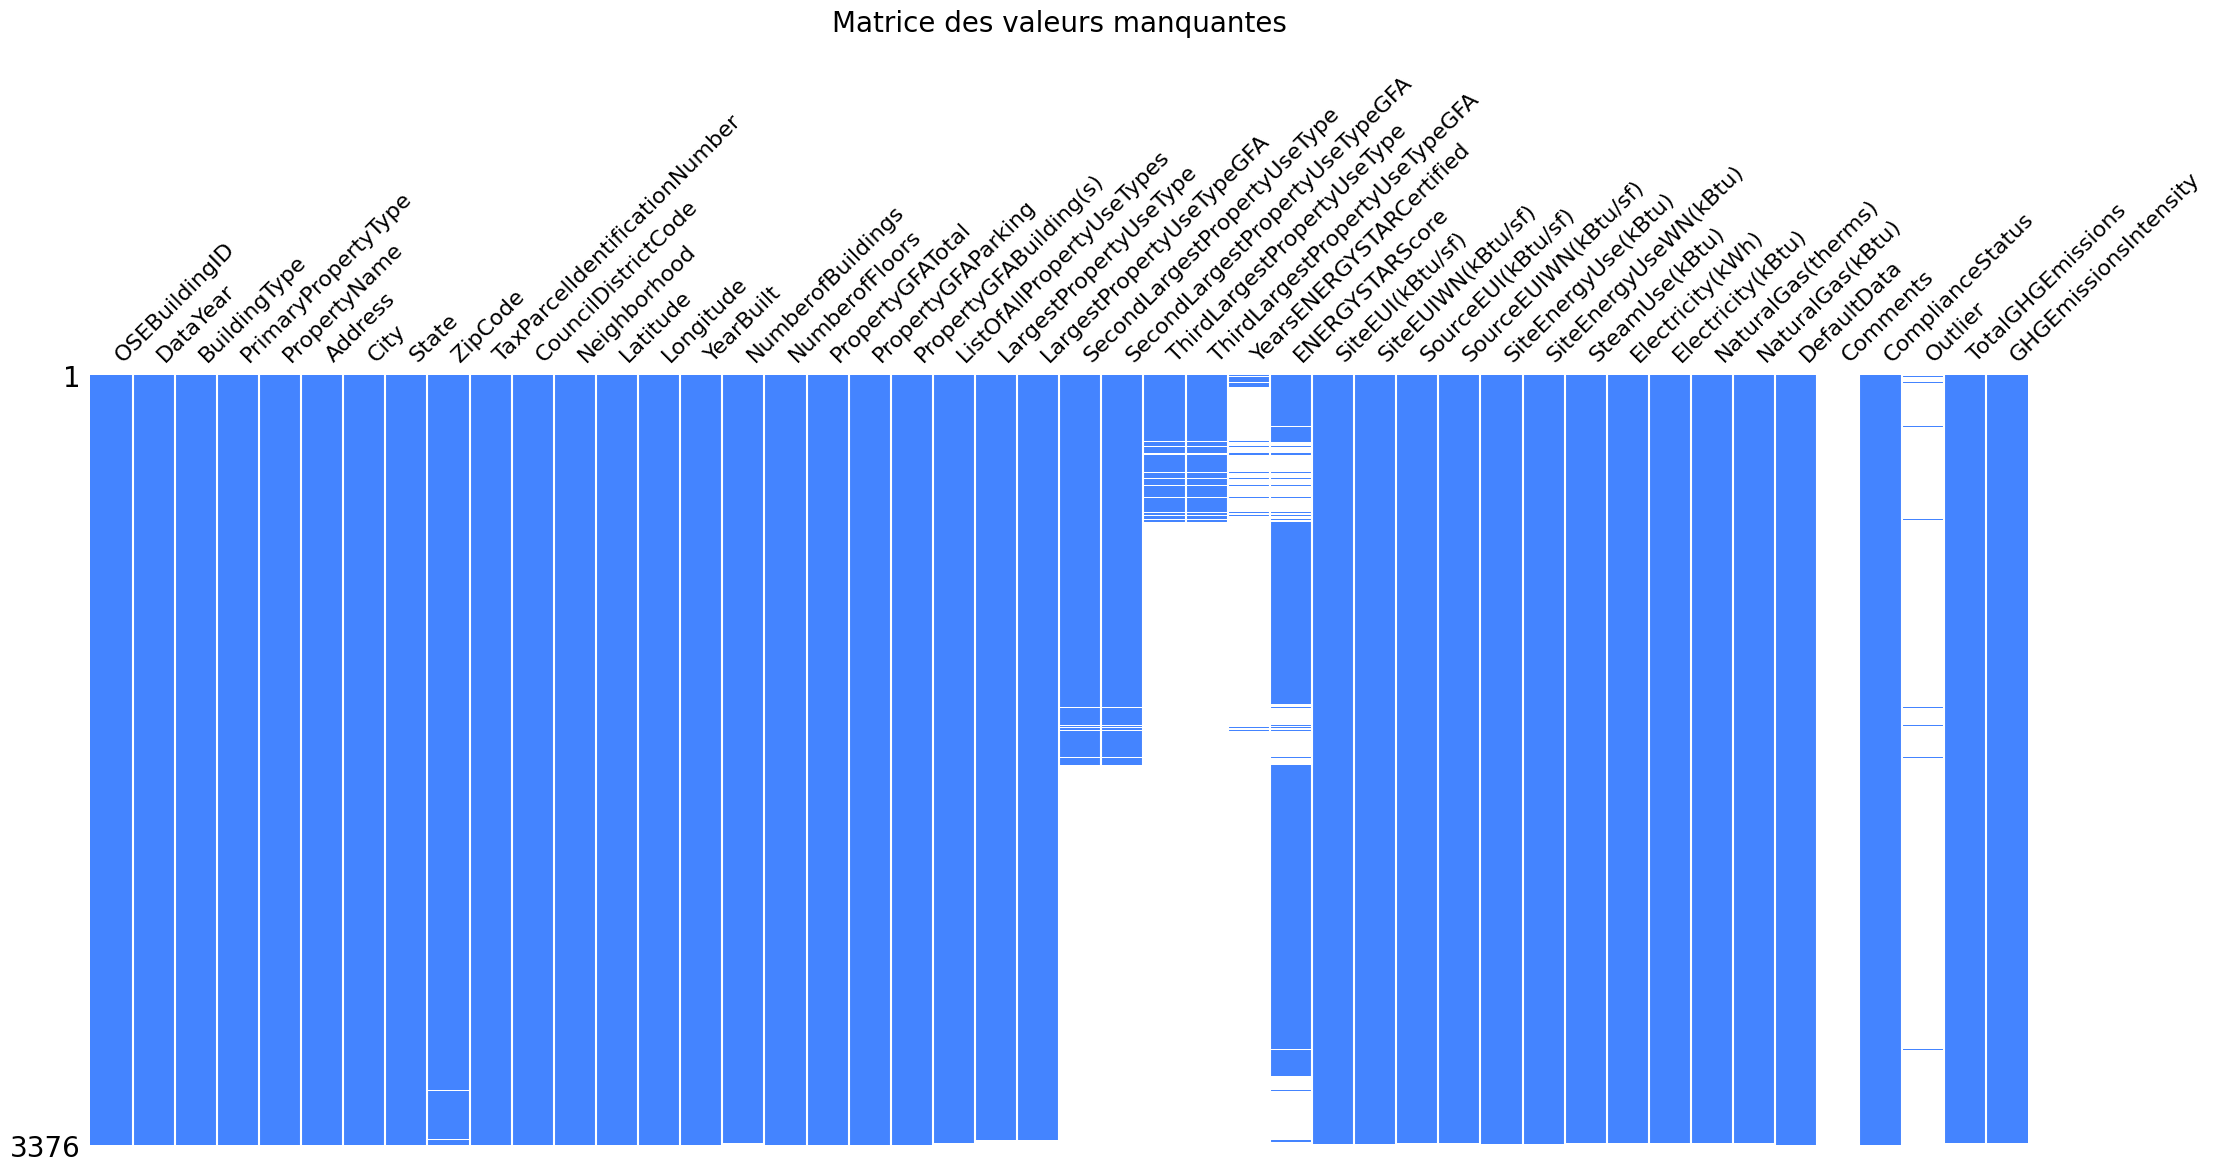

In [186]:
# valeurs manquantes
missing_values_count = df.isna().sum()
missing_values_percent = round(df.isna().mean() * 100, 0)
missing_data = pd.concat([missing_values_count, missing_values_percent], axis = 1)
missing_data.columns = ['NB', '%']
print("VALEURS MANQUANTES :\n", missing_data.sort_values(by = '%', ascending = False ), sep = '', end = '\n\n')

# representons graphiquement les donnees manquantes
msno.matrix(df,
            color=(0.27, 0.52, 1.0),
            sort="descending",
            sparkline = False,
           ).set_title("Matrice des valeurs manquantes\n", fontsize = 20)

# **IV. Nettoyage et imputation**

J'ai choisi les variables suivantes pour prédire les émissions de carbone et la consommation énergétique:

- **Emission de carbone: TotalGHGEmissions** :

Quantité totale d'émission de gaz à effet de serre, y compris le dioxyde de carbone, le méthane et l'oxyde nitreux, rejetée dans l'atmosphère à la suite de la consommation d'énergie sur le site, mesurée en tonne d'équivalent dioxyde de carbone.

- **Consommation énergétique: SiteEnergyUse(kBtu)** :

Consommation énergétique sur site, toutes énergies confondues. En kilo d'unités thermiques britanniques

Dans la partie nettoyage, je vais donc choisir des variables explicatives pour prédire ces 2 variables cibles.


##**A. Nettoyage**

**CONSERVER LES BATIMENTS NON RESIDENTIELS**

In [187]:
# lister les types de bâtiments
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [188]:
# conserver uniquement les bâtiments non résidentiels
non_residential_buildings = [b for b in df['BuildingType'].unique() if 'nonresidential' in b.lower()]
df = df.loc[df['BuildingType'].isin(non_residential_buildings)]

# suppression de la colonne BuildingType
df.drop(columns=['BuildingType'], inplace=True)

<ipython-input-188-a1b7b22bc20d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['BuildingType'], inplace=True)


In [189]:
# vérifier l'usage principal des batiments
df['LargestPropertyUseType'].value_counts()

LargestPropertyUseType
Office                                                  495
Non-Refrigerated Warehouse                              199
Retail Store                                             97
Other                                                    91
Hotel                                                    76
Worship Facility                                         71
Distribution Center                                      54
Supermarket/Grocery Store                                41
Medical Office                                           41
K-12 School                                              39
Other - Recreation                                       31
Parking                                                  29
Self-Storage Facility                                    27
Residence Hall/Dormitory                                 22
Other - Entertainment/Public Assembly                    21
Senior Care Community                                    20
College/Universit

In [190]:
# retirer les bâtiments indiqués comme résidentiel
residential_use=['Residence Hall/Dormitory', 'Multifamily Housing', 'Residential Care Facility', 'Other - Lodging/Residential']
df = df.loc[~df['LargestPropertyUseType'].isin(residential_use)]

**RETIRER LES BATIMENTS ATYPIQUES**

In [191]:
# le statut de conformité indique si un bâtiment satisfait aux exigences de référencement énergétique pour l'année en cours
df['ComplianceStatus'].value_counts()

ComplianceStatus
Compliant                       1476
Non-Compliant                     17
Error - Correct Default Data      13
Missing Data                       1
Name: count, dtype: int64

In [192]:
# je conserve uniquement les bâtiments Compliant
df = df.loc[df['ComplianceStatus'] == 'Compliant']

# je supprime la colonne car elle ne contient plus d'informations intéressantes
df.drop(columns=['ComplianceStatus'], inplace=True)

In [193]:
# indique si les bâtiments sont des outliers
print(df['Outlier'].value_counts())

Series([], Name: count, dtype: int64)


In [194]:
# les batiments outlier ont été filtrés en amont
# je supprime la colonne
df.drop(columns=['Outlier'], inplace=True)

**RETIRER LA COLONNE VIDE**

In [195]:
# retirer la colonne vide
df.drop(columns='Comments', inplace=True)

**RETIRER LES VARIABLES PEU PERTINENTES**

In [196]:
# DefaultData indique si au moins une variable a été imputée automatiquement pour le bâtiment
## Vérification des valeurs pour la qualité de la base
percentage_true = df['DefaultData'].mean() * 100
print(f"% de bâtiments dont au moins une valeur a été imputée: {percentage_true:.2f}%")

# Je supprime car l'information n'est pas pertinente
df.drop(columns=['DefaultData'], inplace=True)

% de bâtiments dont au moins une valeur a été imputée: 0.00%


**SUPPRIMER LES VARIABLES DONT L'INFORMATION EST REDONDANTE**

In [197]:
# pour identifier un batiment de manière unique, j'ai choisi OSEBuildingID
df.drop(columns=['PropertyName', 'TaxParcelIdentificationNumber'], inplace=True)

In [198]:
# pour identifier la localisation, j'ai choisi Neighborhood:
## pour limiter le nombre de variables, j'ai favorisé Neighborhood par rapport au couple (Latitude,Longitude) malgré une perte de précision
## neighborhood peut être choisi car tous les bâtiments sont situés à Seattle
## il manque des valeurs pour ZipCode donc j'ai favorisé Neighborhood
df.drop(columns=['Address', 'City', 'State', 'ZipCode', 'CouncilDistrictCode', 'Latitude', 'Longitude'], inplace=True)

In [199]:
# pour mesurer les émissions de carbones, j'ai choisi TotalGHGEmissions:
## car GHGEmissionsIntensity ne prend pas en compte la surface totale du bâtiment
df.drop(columns=['GHGEmissionsIntensity'], inplace=True)

In [200]:
# pour mesurer la consommation énergétique, j'ai choisi SiteEnergyUse(kBtu):
## car SourceEUIWN et SourceEUI prennent en compte les pertes liées à la production et au transport
## car SiteEUI(kBtu/sf) et SiteEUIWN(kBtu/sf) ne prennent pas en compte la surface totale du bâtiment
## car même si SiteEnergyUseWN(kBtu) retire les effets des variations climatique, les bâtiments sont dans la même ville avec un climat similaire
df.drop(columns=['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)'], inplace=True)

In [201]:
# pour mesurer les variables features, j'ai choisi les variables mesurées en kBtu:
## car l'unité sera uniforme
df.drop(columns=['Electricity(kWh)', 'NaturalGas(therms)'], inplace=True)

In [202]:
# PrimaryPropertyType et ont des informations similaires, je supprime PrimaryPropertyType car LargestPropertyUseType est lié à LargestPropertyUseTypeGFA
df.drop(columns=['PrimaryPropertyType'], inplace=True)

In [203]:
# remplir les valeurs manquantes de LargestPropertyUseType
missing_value = [(col, df[col].isna().sum()) for col in ['ListOfAllPropertyUseTypes', 'LargestPropertyUseType']]
print("missing values:\n", missing_value)

missing values:
 [('ListOfAllPropertyUseTypes', 0), ('LargestPropertyUseType', 4)]


In [204]:
# il manque des valeur, on regarde les valeurs à replacer
print(df[df['LargestPropertyUseType'].isna()])

# on remplace les valeurs manquantes et on supprime la colonne ListOfAllPropertyUseTypes
df.loc[df['OSEBuildingID'] == 496, 'LargestPropertyUseType'] = 'Self-Storage Facility'
df.loc[df['OSEBuildingID'] == 21103, 'LargestPropertyUseType'] = 'Hotel'
df.loc[df['OSEBuildingID'] == 25568, 'LargestPropertyUseType'] = 'Office'
df.loc[df['OSEBuildingID'] == 25711, 'LargestPropertyUseType'] = 'Restaurant'

      OSEBuildingID  DataYear Neighborhood  YearBuilt  NumberofBuildings  \
353             496      2016      BALLARD       1946                2.0   
1147          21103      2016     DOWNTOWN       1910                1.0   
2414          25568      2016   LAKE UNION       2008                1.0   
2459          25711      2016     DOWNTOWN       1913                1.0   

      NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
353                2            111445                   0   
1147               8             61721                   0   
2414               4             48350                   0   
2459               3             28800                   0   

      PropertyGFABuilding(s)  \
353                   111445   
1147                   61721   
2414                   48350   
2459                   28800   

                              ListOfAllPropertyUseTypes  \
353   Fitness Center/Health Club/Gym, Office, Other ...   
1147                         

**FEATURE ENGINEERING**

In [205]:
# récupérer le nombre d'usage par bâtiment
df['NbBuildingUsages'] = df['ListOfAllPropertyUseTypes'].apply(get_nb_of_property_usages)
print(df['NbBuildingUsages'].unique())
df.drop(columns=['ListOfAllPropertyUseTypes'], inplace=True)

[ 1  3  2  5  4  6 11 13  9  7  8]


In [206]:
# je regarde s'il existe des valeurs abérantes
print(df['YearBuilt'].unique(), end='\n')
print(df['DataYear'].unique())

[1927 1996 1969 1926 1980 1999 1904 1998 1928 1922 2004 1930 1983 1907
 1916 1985 2001 1991 1978 1906 1994 1955 1961 1900 1954 1911 1973 1920
 1910 1982 1908 1959 2000 1997 1962 1970 2008 1965 1929 2010 1990 1938
 1986 2002 1923 2003 1941 2006 1915 1950 1958 1971 2007 1951 1964 1953
 1937 1966 1957 1968 1924 2005 1931 1972 1952 1914 1981 1989 1925 1976
 2009 1909 1988 1979 1947 1984 1956 1912 1977 1960 1945 1992 1963 1974
 1975 1946 1995 1967 1987 1949 1940 1932 1948 1993 1918 1905 1902 1921
 1939 1944 1917 1942 1903 2012 2013 1919 1901 1936 1913 1935 2011 2014
 2015]
[2016]


In [207]:
# je crée une nouvelle variable BuildingAge qui remplace les 2 variables précédentes
df['BuildingAge'] = df['DataYear'] - df['YearBuilt']
df.drop(columns=['DataYear', 'YearBuilt'], inplace=True)
df['BuildingAge'].unique()

array([ 89,  20,  47,  90,  36,  17, 112,  18,  88,  94,  12,  86,  33,
       109, 100,  31,  15,  25,  38, 110,  22,  61,  55, 116,  62, 105,
        43,  96, 106,  34, 108,  57,  16,  19,  54,  46,   8,  51,  87,
         6,  26,  78,  30,  14,  93,  13,  75,  10, 101,  66,  58,  45,
         9,  65,  52,  63,  79,  50,  59,  48,  92,  11,  85,  44,  64,
       102,  35,  27,  91,  40,   7, 107,  28,  37,  69,  32,  60, 104,
        39,  56,  71,  24,  53,  42,  41,  70,  21,  49,  29,  67,  76,
        84,  68,  23,  98, 111, 114,  95,  77,  72,  99,  74, 113,   4,
         3,  97, 115,  80, 103,  81,   5,   2,   1])

In [208]:
# je regarde les valeurs
to_check = 'YearsENERGYSTARCertified'
print('raw:\n', df[to_check].unique(), end='\n\n')
print(df[to_check].dtypes) # perte d'informations à cause du format de données

raw:
 [None '2016' '2014' '2012' '20172015' '2,0172E+39' '2,0102E+11'
 '2,0172E+11' '20162015' '2,0152E+19' '2,0122E+11' '2,0162E+35'
 '2,0162E+11' '2,0162E+19' '2,0162E+51' '2,0152E+11' '2,0142E+27'
 '2,0162E+15' '2,0172E+27' '2,0172E+23' '2,0152E+15' '2007' '2010'
 '2,0172E+19' '2,0172E+15' '2015' '2017' '2,0172E+35' '20092005'
 '2,0122E+15' '20112009' '2009' '2,0162E+23' '2,0162E+27' '20102008'
 '20162012' '2,0162E+31' '2,0142E+15' '2,0162E+59' '2011' '20172016'
 '2013' '20152012']

object


In [209]:
# je peux déduire 2 informations:
## le nombre d'années où la certification a été obtenue
## la dernière année d'obtention du certificat

# création des 2 nouvelles variables
df['LastYearENERGYSTARCertified'] = df['YearsENERGYSTARCertified'].apply(last_year_certified)
df['NbYearENERGYSTARCertified']   = df['YearsENERGYSTARCertified'].apply(count_years_certified)

# vérification de la transformation
print(df['LastYearENERGYSTARCertified'].unique(), df['NbYearENERGYSTARCertified'].unique())

# suppression de l'ancienne colonne
df.drop(columns=['YearsENERGYSTARCertified'], inplace=True)

[  nan 2016. 2014. 2012. 2017. 2010. 2015. 2007. 2009. 2011. 2013.] [ 0  1  2 10  3  5  9 13  7  4  6  8 15]


In [210]:
# Eviter le data leakage
## Je créé des ratios car seul les valeurs d'une année de SteamUse, Electricity et NaturalGas seront disponibles

df['RatioSteamUse'] = round(df['SteamUse(kBtu)']/ (df['SteamUse(kBtu)'] + df['Electricity(kBtu)'] + df['NaturalGas(kBtu)']), 2)
df['RatioElectricity'] = round(df['Electricity(kBtu)']/ (df['SteamUse(kBtu)'] + df['Electricity(kBtu)'] + df['NaturalGas(kBtu)']), 2)
df['RatioNaturalGas'] = round(df['NaturalGas(kBtu)']/ (df['SteamUse(kBtu)'] + df['Electricity(kBtu)'] + df['NaturalGas(kBtu)']), 2)

In [211]:
df.reset_index()

,index,OSEBuildingID,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,NbBuildingUsages,BuildingAge,LastYearENERGYSTARCertified,NbYearENERGYSTARCertified,RatioSteamUse,RatioElectricity,RatioNaturalGas
0,0,1,DOWNTOWN,1.0,12,88434,0,88434,Hotel,88434.0,None,NaN,None,NaN,60.0,7.226362e+06,2003882.00,3.946027e+06,1.276453e+06,249.98,1,89,NaN,0,0.28,0.55,0.18
1,1,2,DOWNTOWN,1.0,11,103566,15064,88502,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,8.387933e+06,0.00,3.242851e+06,5.145082e+06,295.86,3,20,NaN,0,0.00,0.39,0.61
2,2,3,DOWNTOWN,1.0,41,956110,196718,759392,Hotel,756493.0,None,NaN,None,NaN,43.0,7.258702e+07,21566554.00,4.952666e+07,1.493800e+06,2089.28,1,47,NaN,0,0.30,0.68,0.02
3,3,5,DOWNTOWN,1.0,10,61320,0,61320,Hotel,61320.0,None,NaN,None,NaN,56.0,6.794584e+06,2214446.25,2.768924e+06,1.811213e+06,286.43,1,90,NaN,0,0.33,0.41,0.27
4,4,8,DOWNTOWN,1.0,18,175580,62000,113580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,1.417261e+07,0.00,5.368607e+06,8.803998e+06,505.01,3,36,NaN,0,0.00,0.38,0.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,3370,50221,DELRIDGE NEIGHBORHOODS,1.0,1,18261,0,18261,Other - Recreation,18261.0,None,NaN,None,NaN,NaN,9.320821e+05,0.00,6.323620e+05,2.997200e+05,20.33,1,34,NaN,0,0.00,0.68,0.32
1472,3372,50223,DOWNTOWN,1.0,1,16000,0,16000,Other - Recreation,16000.0,None,NaN,None,NaN,NaN,9.502762e+05,0.00,3.965461e+05,5.537300e+05,32.17,1,12,NaN,0,0.00,0.42,0.58
1473,3373,50224,MAGNOLIA / QUEEN ANNE,1.0,1,13157,0,13157,Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,5.765898e+06,0.00,1.792159e+06,3.973739e+06,223.54,3,42,NaN,0,0.00,0.31,0.69
1474,3374,50225,GREATER DUWAMISH,1.0,1,14101,0,14101,Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,NaN,7.194712e+05,0.00,3.488702e+05,3.706010e+05,22.11,5,27,NaN,0,0.00,0.48,0.52


**NETTOYAGE DES MODALITES QUALITATIVES**

In [212]:
# vérification de la cohérence des données
to_check = 'Neighborhood'
print('raw:\n', df[to_check].unique(), end='\n\n')

# harmonisation des données
mapping = {
  'North': 'NORTH',
  'Delridge': 'DELRIDGE',
  'DELRIDGE NEIGHBORHOODS': 'DELRIDGE',
  'Northwest': 'NORTHWEST',
  'Ballard': 'BALLARD',
  'Central': 'CENTRAL'
}

df[to_check] = df[to_check].replace(mapping)
print(f'valeurs mises à jour dans la variable {to_check} :\n', df[to_check].unique())

raw:
 ['DOWNTOWN' 'NORTHEAST' 'EAST' 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD'
 'NORTHWEST' 'MAGNOLIA / QUEEN ANNE' 'CENTRAL' 'SOUTHWEST' 'SOUTHEAST'
 'NORTH' 'DELRIDGE' 'North' 'Delridge' 'Ballard' 'Northwest' 'Central'
 'DELRIDGE NEIGHBORHOODS']

valeurs mises à jour dans la variable Neighborhood :
 ['DOWNTOWN' 'NORTHEAST' 'EAST' 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD'
 'NORTHWEST' 'MAGNOLIA / QUEEN ANNE' 'CENTRAL' 'SOUTHWEST' 'SOUTHEAST'
 'NORTH' 'DELRIDGE']


##**B. Imputation**

In [213]:
# valeurs manquantes
missing_values_count = df.isna().sum()
missing_values_percent = round(df.isna().mean() * 100, 0)
missing_data = pd.concat([missing_values_count, missing_values_percent], axis = 1)
missing_data.columns = ['NB', '%']
missing_data = missing_data[missing_data['NB'] != 0]
print("VALEURS MANQUANTES :\n", missing_data.sort_values(by = '%', ascending = False ), sep = '', end = '\n\n')

VALEURS MANQUANTES :
                                   NB     %
LastYearENERGYSTARCertified      1385  94.0
ThirdLargestPropertyUseType      1148  78.0
ThirdLargestPropertyUseTypeGFA   1148  78.0
SecondLargestPropertyUseType      665  45.0
SecondLargestPropertyUseTypeGFA   665  45.0
ENERGYSTARScore                   515  35.0
LargestPropertyUseTypeGFA           4   0.0
RatioSteamUse                       1   0.0
RatioElectricity                    1   0.0
RatioNaturalGas                     1   0.0



In [214]:
# suppression des variables avec beaucoup de valeurs manquantes
df.drop(columns=['ThirdLargestPropertyUseType'], inplace=True)
df.drop(columns=['ThirdLargestPropertyUseTypeGFA'], inplace=True)
df.drop(columns=['SecondLargestPropertyUseType'], inplace=True)
df.drop(columns=['SecondLargestPropertyUseTypeGFA'], inplace=True)

In [215]:
# pour LastYearENERGYSTARCertified l'absence de valeurs signifie que le bâtiment n'a jamais été certifié
df['LastYearENERGYSTARCertified'].fillna(0, inplace=True)

In [216]:
# remplir par une modalité par défaut
df['LargestPropertyUseType'].fillna("missing", inplace=True)

In [217]:
# imputation des variables ENERGYSTARScore et LargestPropertyUseTypeGFA
impute_knn = KNNImputer(n_neighbors=3)
columns_to_impute = ['ENERGYSTARScore', 'LargestPropertyUseTypeGFA']
df[columns_to_impute] = impute_knn.fit_transform(df[columns_to_impute])

# imputation des variables ratio d'énergie
impute_knn = KNNImputer(n_neighbors=3)
columns_to_impute = ['RatioSteamUse', 'RatioElectricity', 'RatioNaturalGas']
df[columns_to_impute] = impute_knn.fit_transform(df[columns_to_impute])

**SUPPRIMER LES VALEURS ABERRANTES**

In [218]:
mask = (df['TotalGHGEmissions'] <= 0)
df = df[~mask]
df.reset_index(drop=True, inplace=True)

# **V. Analyse uni et bivariée**

Pour résumé, j'ai choisi les variables à prédire TotalGHGEmissions et SiteEnergyUse(kBtu).

Les variables explicatives peuvent être catégorisées sous les labels suivants:

- **LA CONSOMMATION ENERGERIQUE** (RatioSteamUse, RatioElectricity, RatioNaturalGas(kBtu))
- **LE SCORE ENERGETIQUE** (ENERGYSTARScore, LastYearENERGYSTARCertified, NbYearENERGYSTARCertified)
- **LES CARACTERISTIQUES PHYSIQUES DU BATIMENT**
(NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking,
PropertyGFABuilding(s), LargestPropertyUseTypeGFA, BuildingAge)
- **LES USAGES** (PrimaryPropertyType, LargestPropertyUseType, NbBuildingUsages)
- **LA LOCALISATION** (Neighborhood).


##**A. Analyse univariée**

###**1. Variables qualitatives**

In [219]:
# statistiques des variables qualitatives
print("VARIABLES QUALITATIVES :")
df.describe(exclude=[np.number])

VARIABLES QUALITATIVES :


,Neighborhood,LargestPropertyUseType
count,1474,1474
unique,13,51
top,DOWNTOWN,Office
freq,338,483


LargestPropertyUseType contient une information plus fine que PrimaryPropertyType (51 modalités contre 19)

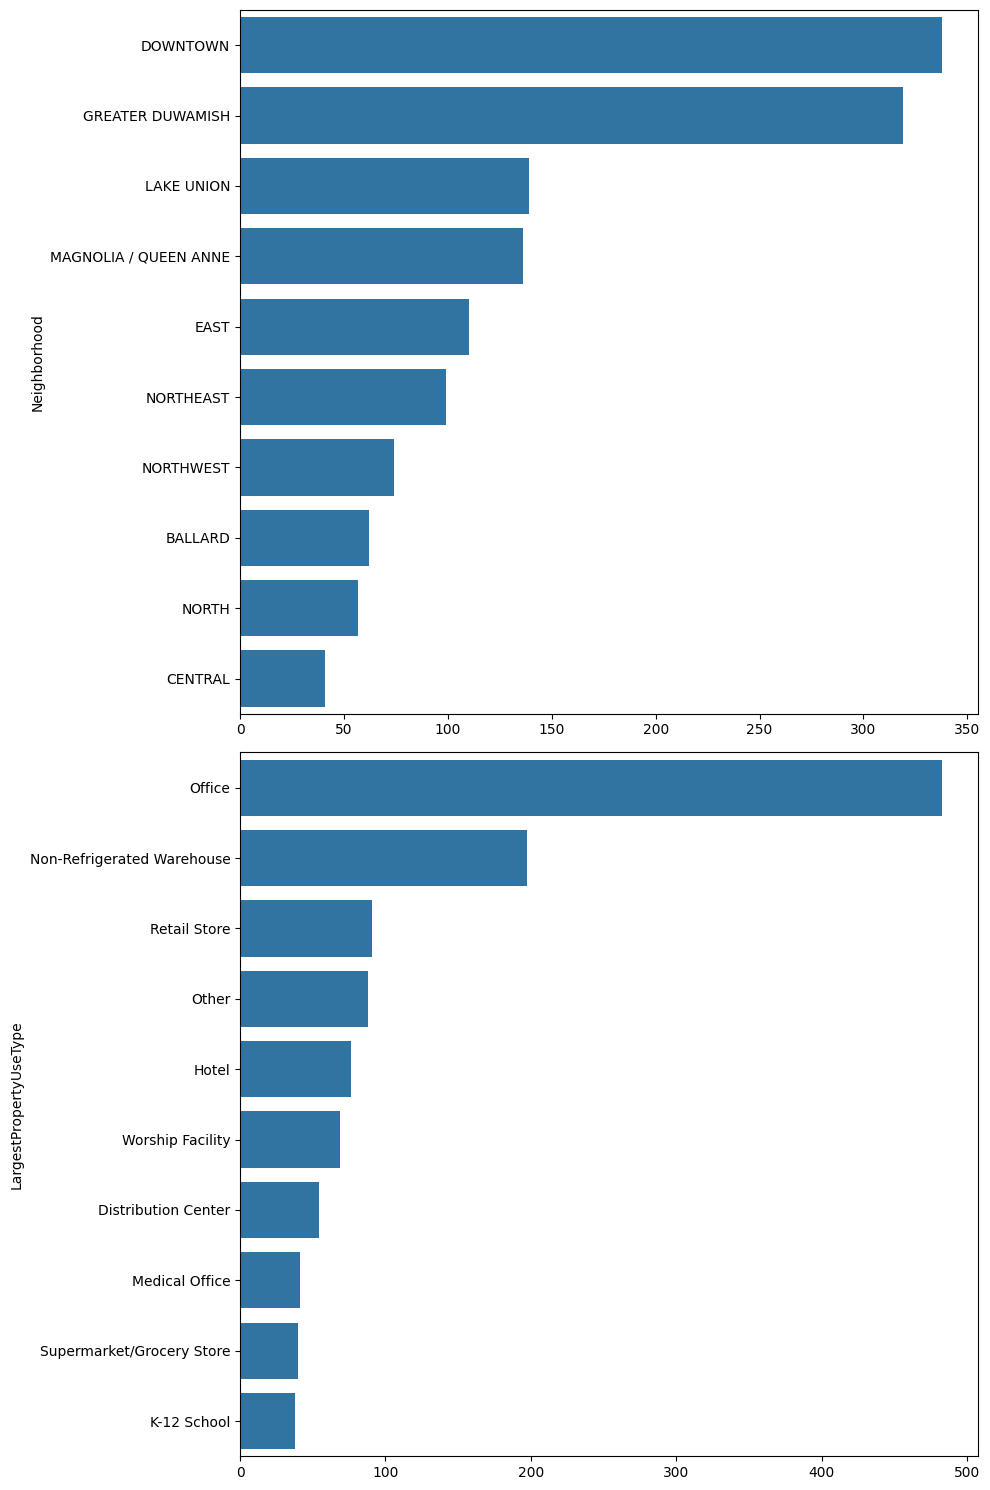

In [220]:
# TOP 10 des modalités de chaque variable qualitative
L = ['Neighborhood', 'LargestPropertyUseType']
fig, axes = plt.subplots(nrows=len(L), ncols=1, figsize=(10,15))

for i, col in enumerate(L):
  df_graph = df[col].value_counts().sort_values(ascending=False)
  sns.barplot(x=df_graph[:10].values, y=df_graph[:10].index, ax=axes[i])

plt.tight_layout()
plt.show()

Les 2 quartiers les plus représentés sont DOWNTOWN et GREATER DUWAMISH avec plus de 300 bâtiments présents dans le jeu de données nettoyés.

Les types de bâtiments les plus représentés sont les bureaux, suivi des entrepôts, des commerces de détail et des lieux de culte.

###**2. Variables quantitatives**

In [221]:
# statistiques des variables quantitatives
print("VARIABLES QUANTITATIVES :\n")
df.describe().apply(lambda s: s.apply('{0:.0f}'.format))

VARIABLES QUANTITATIVES :



,OSEBuildingID,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,NbBuildingUsages,BuildingAge,LastYearENERGYSTARCertified,NbYearENERGYSTARCertified,RatioSteamUse,RatioElectricity,RatioNaturalGas
count,1474,1474,1474,1474,1474,1474,1474,1474,1474,1474,1474,1474,1474,1474,1474,1474,1474,1474,1474,1474
mean,16251,1,4,112881,14265,98616,92001,62,7825233,514788,5558416,1714046,170,2,55,124,0,0,1,0
std,13735,1,7,190962,44552,166859,157536,26,19018618,5429131,13261888,5623495,583,1,33,485,1,0,0,0
min,1,0,0,11285,0,3636,5656,1,57133,0,0,0,0,1,1,0,0,0,0,0
25%,600,1,1,28811,0,27884,25040,46,1225168,0,727034,0,20,1,28,0,0,0,0,0
50%,21142,1,2,47831,0,45792,41628,65,2687720,0,1727940,444521,49,2,51,0,0,0,1,0
75%,24580,1,4,103664,0,93596,90000,83,7248760,0,5247486,1438989,142,2,86,0,0,0,1,0
max,50226,9,99,1952220,512608,1765970,1680937,100,293090784,134943456,274532495,138191238,12307,13,116,2017,15,1,1,1


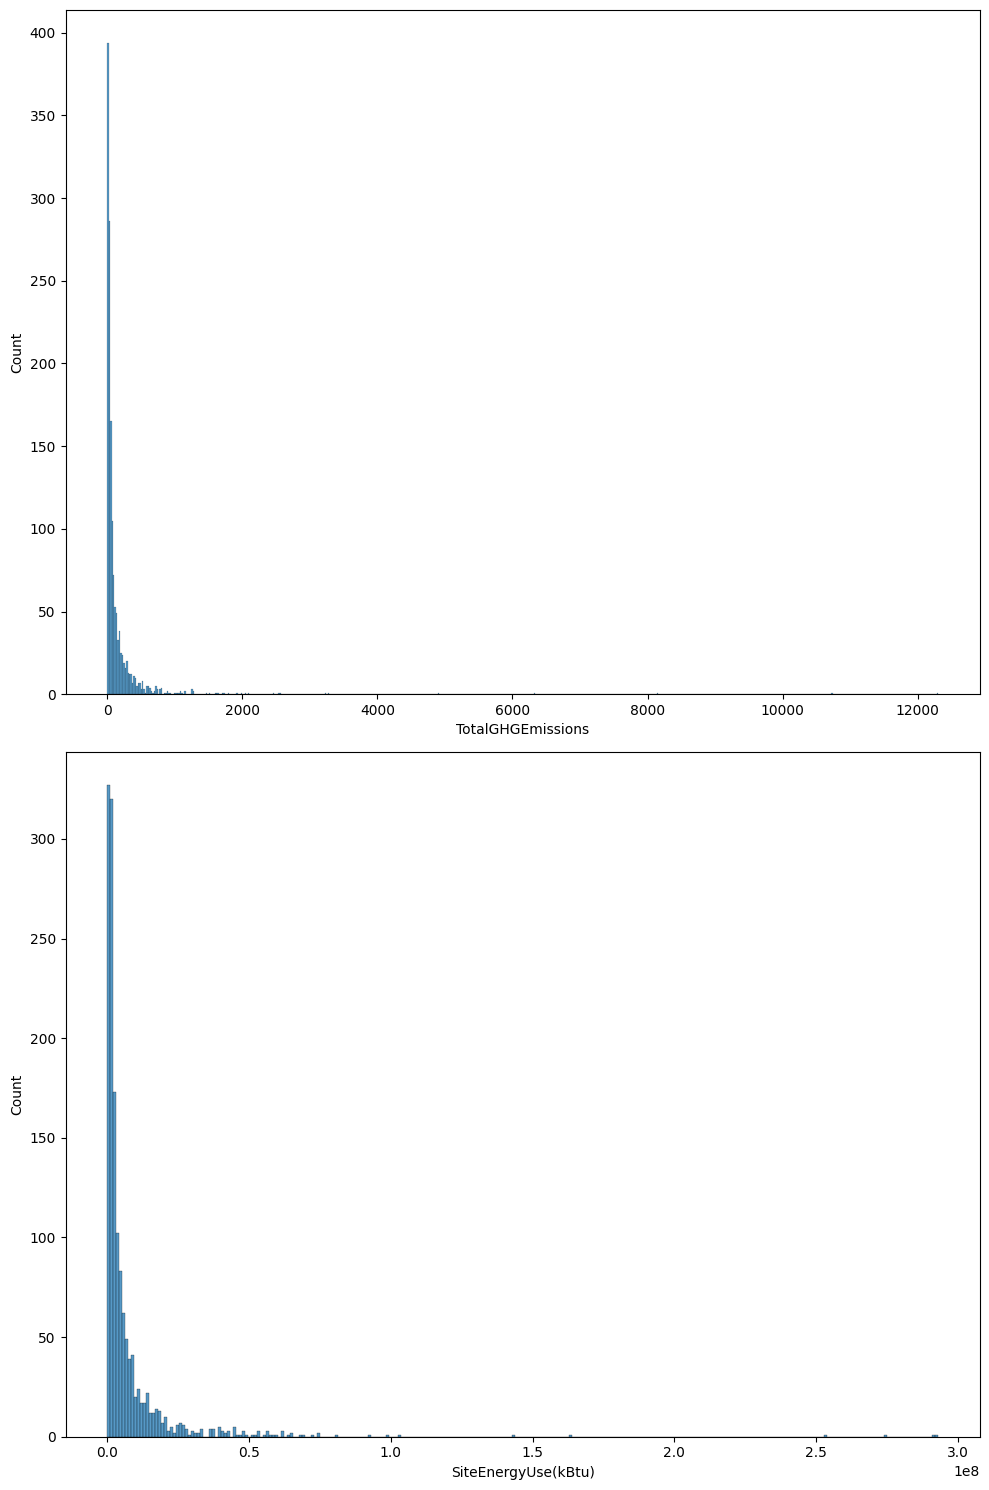

In [222]:
# variables à prédire
L_num = ['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']
fig, axes = plt.subplots(nrows=len(L_num), ncols=1, figsize=(10,15))

for i, col in enumerate(L_num):
  df_graph = df[col]
  sns.histplot(x=df_graph, ax=axes[i])

plt.tight_layout()
plt.show()

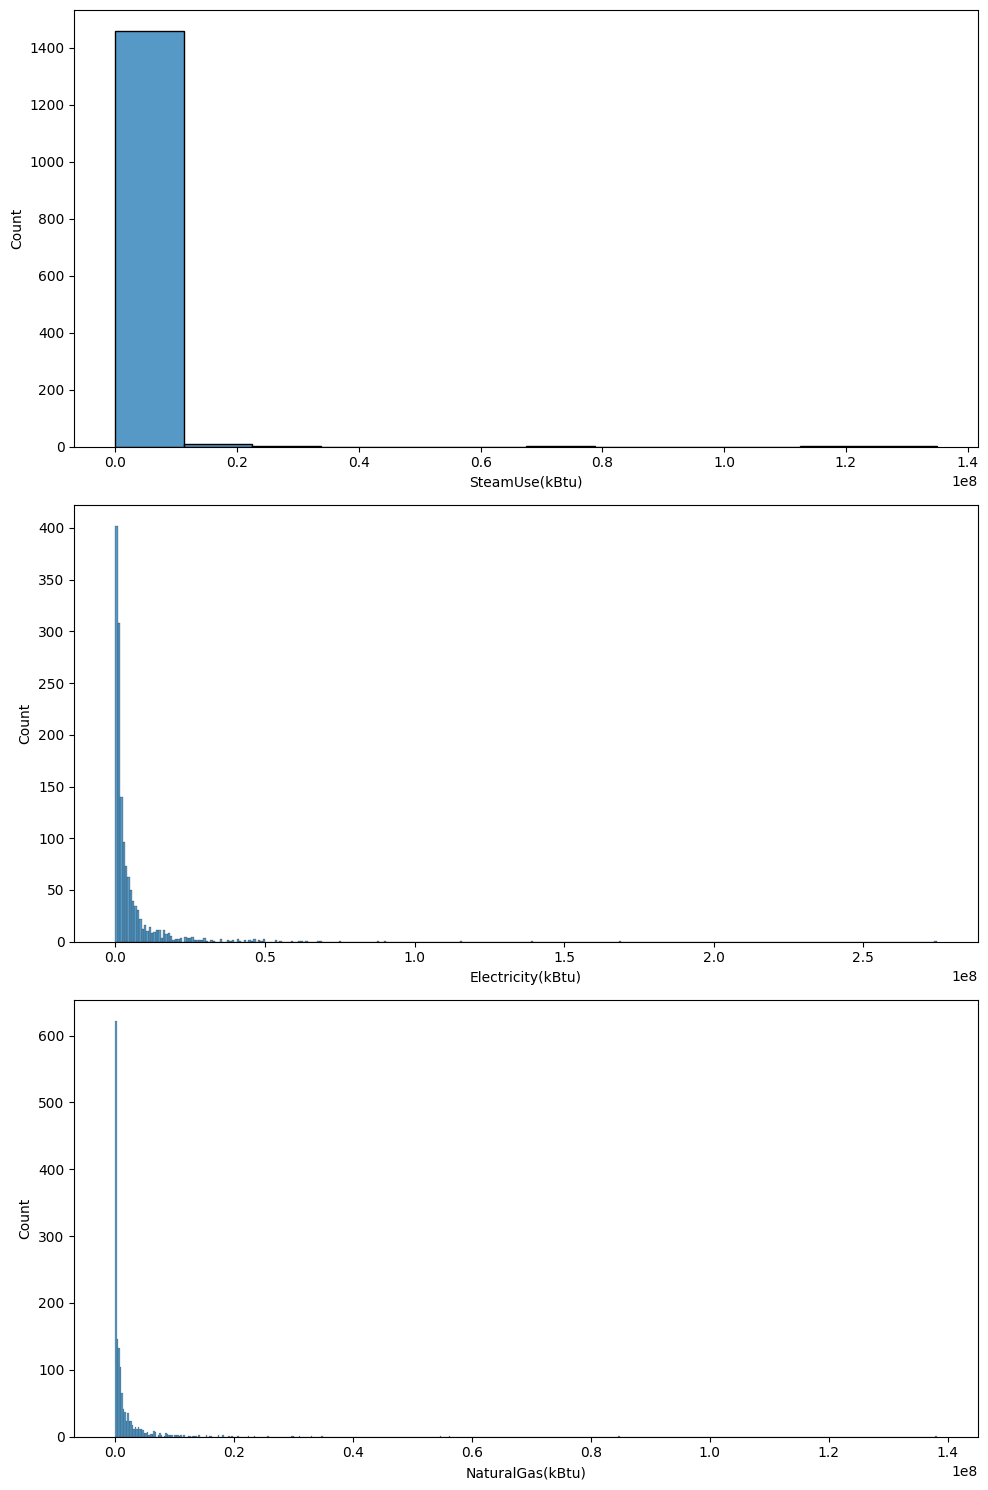

In [223]:
# variables de consommation énergétique
L_num = ['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']
fig, axes = plt.subplots(nrows=len(L_num), ncols=1, figsize=(10,15))

for i, col in enumerate(L_num):
  df_graph = df[col]
  sns.histplot(x=df_graph, ax=axes[i])

plt.tight_layout()
plt.show()

Au vue de la forme des différentes distribution qui présente des valeurs extrèmes, il faut effectuer un feature engineering comme un passage au log. Mais je ne vais pas utiliser ces variables.

##**B. Analyse bivariée**

###**1. Moyenne des 2 variables cibles selon le type d'usage, le quartier et l'âge des bâtiments**

Les variables de surface totale et de surface totale de l'utilisation principale d'une propriété sont naturellement corrélées car la surface de l'usage principale d'une propriété représente souvent un grand pourcentage de la surface totale. D'où la forte corrélation positive (98%) et la linéarité observée dans le nuage de points entre ces variables.

Le raisonnement est similaire pour le nombre de bâtiments. Plus il y a de batiments, plus la surface totale est grande.

On note également une forte corrélation entre la consommation en électricité avec la consommation énergétique. Et l'émission de carbonne avec la consommation en électricité et la consommation d'énergie sous forme de thermique.

**VARIABLE CIBLE 1. EMISSIONS DE CARBONE**

In [224]:
# emissions de carbone moyenne par type de batiment
# emissions de carbone moyenne par quartier
# emissions de carbone moyenne selon l'âge du bâtiment
GHGEmissions_per_usage = df.groupby(['LargestPropertyUseType']).agg({'TotalGHGEmissions': 'mean'})
GHGEmissions_per_usage.sort_values(by='TotalGHGEmissions', ascending=False, inplace=True)
print(GHGEmissions_per_usage.head(10), end='\n\n')

GHGEmissions_per_neighborhood = df.groupby(['Neighborhood']).agg({'TotalGHGEmissions': 'mean'})
GHGEmissions_per_neighborhood.sort_values(by='TotalGHGEmissions', ascending=False, inplace=True)
print(GHGEmissions_per_neighborhood.head(10))

                                       TotalGHGEmissions
LargestPropertyUseType                                  
Hospital (General Medical & Surgical)        5052.963000
Courthouse                                   1265.290000
Laboratory                                    815.766154
Data Center                                   807.266667
Lifestyle Center                              539.965000
Urgent Care/Clinic/Other Outpatient           512.062500
Hotel                                         386.380789
Senior Care Community                         371.899500
Police Station                                301.810000
Other - Entertainment/Public Assembly         299.825238

                       TotalGHGEmissions
Neighborhood                            
EAST                          488.545182
DOWNTOWN                      215.744497
NORTHEAST                     204.212121
CENTRAL                       196.742683
LAKE UNION                    174.004101
SOUTHWEST                   

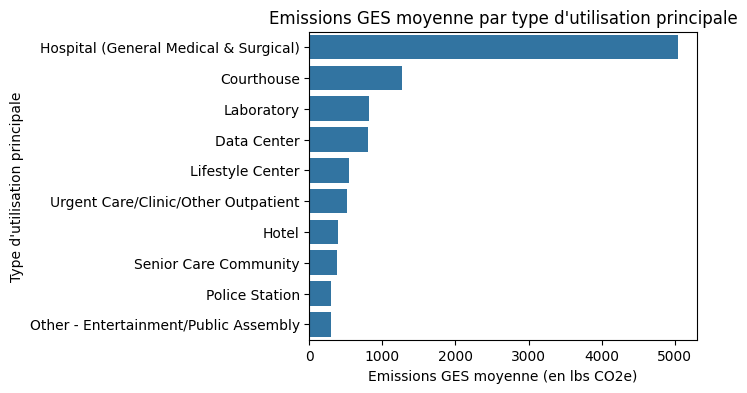

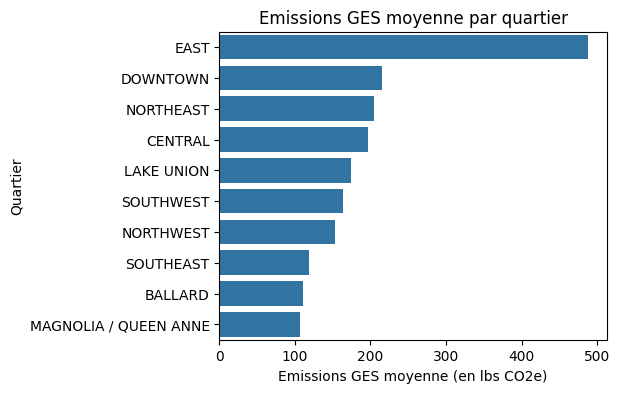

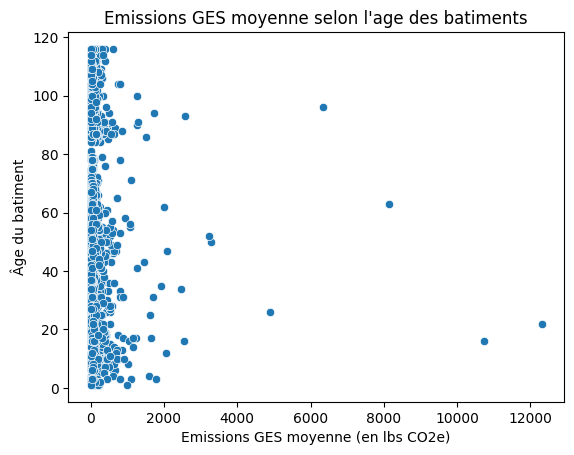

In [225]:
# par usage
plt.figure(figsize=(5, 4))
conso_values = GHGEmissions_per_usage['TotalGHGEmissions'].head(10)
TOP10_GHG_USAGE_TYPES = conso_values.index
sns.barplot(x=conso_values, y=TOP10_GHG_USAGE_TYPES)
plt.ylabel('Type d\'utilisation principale')
plt.xlabel('Emissions GES moyenne (en lbs CO2e)')
plt.title('Emissions GES moyenne par type d\'utilisation principale')
plt.show()

# par quartier
plt.figure(figsize=(5, 4))
conso_values = GHGEmissions_per_neighborhood['TotalGHGEmissions'].head(10)
TOP10_GHG_NEIGHBORHOOD_NAME = conso_values.index
sns.barplot(x=conso_values, y=TOP10_GHG_NEIGHBORHOOD_NAME)
plt.ylabel('Quartier')
plt.xlabel('Emissions GES moyenne (en lbs CO2e)')
plt.title('Emissions GES moyenne par quartier')
plt.show()

# par age
sns.scatterplot(x=df['TotalGHGEmissions'], y=df['BuildingAge'])
plt.ylabel('Âge du batiment')
plt.xlabel('Emissions GES moyenne (en lbs CO2e)')
plt.title('Emissions GES moyenne selon l\'age des batiments')
plt.show()

Les hopitaux sont les champions des émissions de carbones. Ils sont suivis par les tribunaux, les laboratoires et les data center.

Le quartier EAST émet davantage de carbone par rapport aux autres quartiers.

Il n'y a pas de corrélation entre l'âge des bâtiments et les émissions de carbones. Cette observation est appuyée par la matrice de corrélations vue dans la partie précédente.

**VARIABLE CIBLE 2. CONSOMMMATION ENERGETIQUE**

In [226]:
# consommation énergétique moyenne par type de batiment
# consommation énergétique moyenne par quartier
# consommation énergétique moyenne selon l'age du batiment
conso_per_usage = df.groupby(['LargestPropertyUseType']).agg({'SiteEnergyUse(kBtu)': 'mean'})
conso_per_usage.sort_values(by='SiteEnergyUse(kBtu)', ascending=False, inplace=True)
print(conso_per_usage.head(10), end='\n\n')

conso_per_neighborhood = df.groupby(['Neighborhood']).agg({'SiteEnergyUse(kBtu)': 'mean'})
conso_per_neighborhood.sort_values(by='SiteEnergyUse(kBtu)', ascending=False, inplace=True)
print(conso_per_neighborhood.head(10))

                                       SiteEnergyUse(kBtu)
LargestPropertyUseType                                    
Hospital (General Medical & Surgical)         1.415470e+08
Data Center                                   1.154671e+08
Courthouse                                    4.498447e+07
Laboratory                                    2.736661e+07
Urgent Care/Clinic/Other Outpatient           2.527676e+07
Lifestyle Center                              1.952247e+07
Parking                                       1.530626e+07
Other - Mall                                  1.525270e+07
Wholesale Club/Supercenter                    1.342408e+07
Other - Entertainment/Public Assembly         1.269429e+07

                       SiteEnergyUse(kBtu)
Neighborhood                              
EAST                          1.436411e+07
DOWNTOWN                      1.231341e+07
LAKE UNION                    9.525012e+06
NORTHEAST                     8.657265e+06
CENTRAL                       7.3

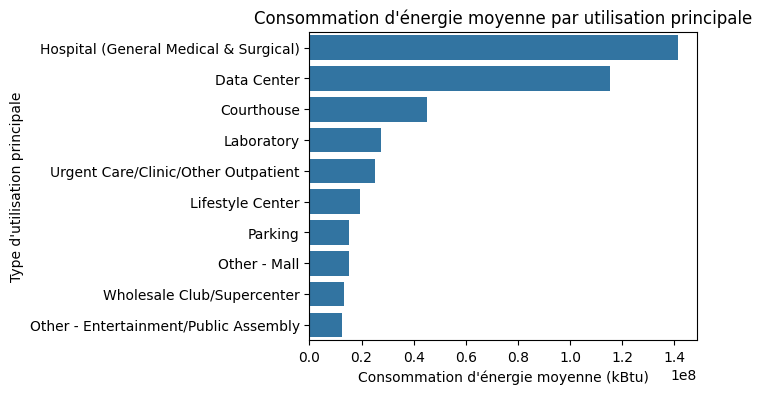

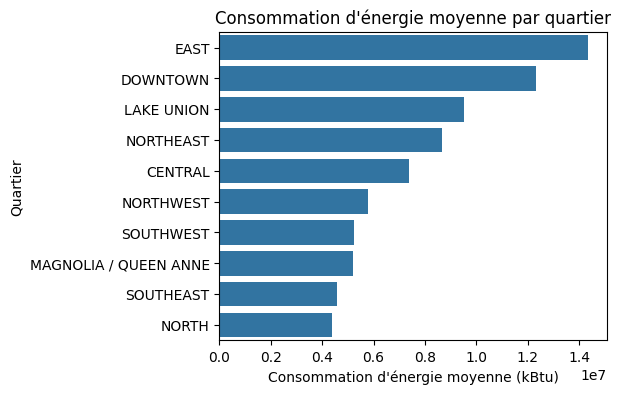

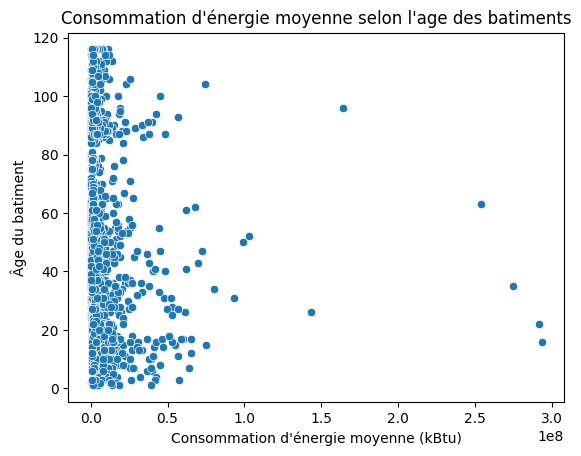

In [227]:
# par usage
plt.figure(figsize=(5, 4))
conso_values = conso_per_usage['SiteEnergyUse(kBtu)'].head(10)
TOP10_ELEC_USAGE_TYPES = conso_values.index
sns.barplot(x=conso_values, y=TOP10_ELEC_USAGE_TYPES)
plt.ylabel('Type d\'utilisation principale')
plt.xlabel('Consommation d\'énergie moyenne (kBtu)')
plt.title('Consommation d\'énergie moyenne par utilisation principale')
plt.show()

# par quartier
plt.figure(figsize=(5, 4))
conso_values = conso_per_neighborhood['SiteEnergyUse(kBtu)'].head(10)
TOP10_ELEC_NEIGHBORHOOD_NAME = conso_values.index
sns.barplot(x=conso_values, y=TOP10_ELEC_NEIGHBORHOOD_NAME)
plt.ylabel('Quartier')
plt.xlabel('Consommation d\'énergie moyenne (kBtu)')
plt.title('Consommation d\'énergie moyenne par quartier')
plt.show()

# par age
sns.scatterplot(x=df['SiteEnergyUse(kBtu)'], y=df['BuildingAge'])
plt.ylabel('Âge du batiment')
plt.xlabel('Consommation d\'énergie moyenne (kBtu)')
plt.title('Consommation d\'énergie moyenne selon l\'age des batiments')
plt.show()

Les mêmes tendances sont observées ici.

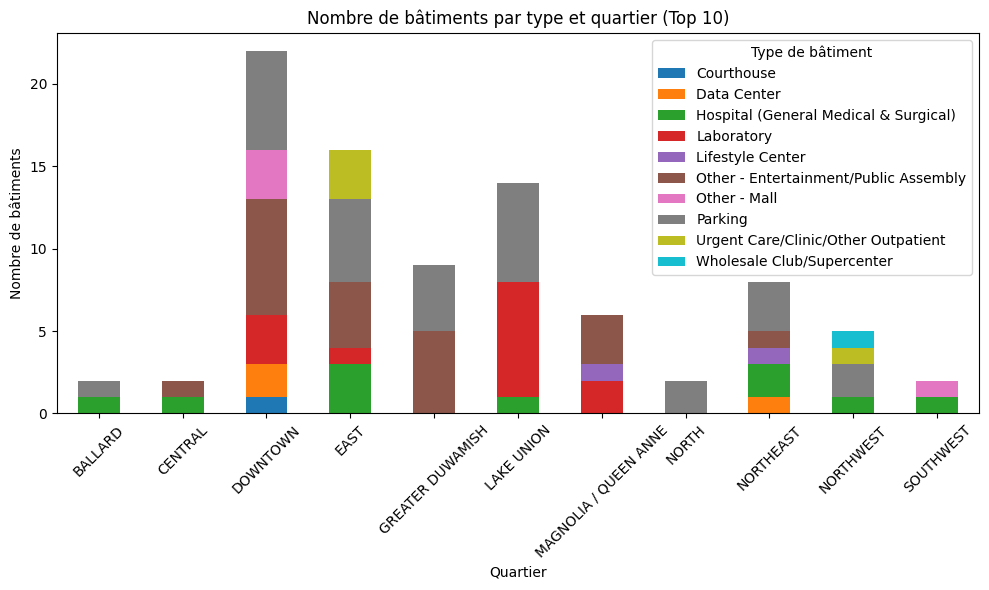

In [228]:
# grouper les batiments selon la Localisation et le TypeDeBatiment

# limiter les modalités de LargestPropertyUseType aux 10 qui consomment le plus d'énergie
df_graph = df[df['LargestPropertyUseType'].isin(TOP10_ELEC_USAGE_TYPES)]

# grouper les bâtiments selon la Localisation et le TypeDeBatiment
aggregated_info = df_graph.groupby(['Neighborhood', 'LargestPropertyUseType']).size().unstack(fill_value=0)

# afficher les informations agrégées sous forme d'histogramme
aggregated_info.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Quartier')
plt.ylabel('Nombre de bâtiments')
plt.title('Nombre de bâtiments par type et quartier (Top 10)')
plt.legend(title='Type de bâtiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Les quartiers EAST et DOWNTOWN sont les 2 premiers dans le classement des émissions de carbone et de la consommation énergétique.

Pour le quartier EAST, cela s'explique par le fait qu'il y a plusieurs hôpitaux qui sont comme on a vu précédemment de gros émetteurs de carbone et consommateur énergétique.

Pour le quartier DOWNTOWN, cela s'explique via le même raisonnement. Il y a en effet un tribunal et de nombreux laboratoires.

###**2. Moyenne du mix énergétique selon le type d'usage et le quartier**

In [229]:
# emissions de carbone moyenne par type de batiment
# emissions de carbone moyenne par quartier
energyMix_per_usage = df.groupby(['LargestPropertyUseType']).agg({'SteamUse(kBtu)': 'mean', 'Electricity(kBtu)': 'mean', 'NaturalGas(kBtu)': 'mean'})
energyMix_per_usage.sort_values(by='Electricity(kBtu)', ascending=False, inplace=True)
print(energyMix_per_usage.head(10), end='\n\n')

energyMix_per_neighborhood = df.groupby(['Neighborhood']).agg({'SteamUse(kBtu)': 'mean', 'Electricity(kBtu)': 'mean', 'NaturalGas(kBtu)': 'mean'})
energyMix_per_neighborhood.sort_values(by='Electricity(kBtu)', ascending=False, inplace=True)
print(energyMix_per_neighborhood.head(10))

                                       SteamUse(kBtu)  Electricity(kBtu)  \
LargestPropertyUseType                                                     
Data Center                              0.000000e+00       1.154172e+08   
Hospital (General Medical & Surgical)    3.314040e+07       7.071191e+07   
Courthouse                               0.000000e+00       2.435783e+07   
Urgent Care/Clinic/Other Outpatient      1.774415e+06       1.892032e+07   
Laboratory                               2.386938e+06       1.506648e+07   
Parking                                  0.000000e+00       1.333621e+07   
Other - Mall                             0.000000e+00       1.320405e+07   
Lifestyle Center                         0.000000e+00       1.076910e+07   
Wholesale Club/Supercenter               0.000000e+00       1.030730e+07   
Other - Entertainment/Public Assembly    1.181804e+06       8.730731e+06   

                                       NaturalGas(kBtu)  
LargestPropertyUseType       

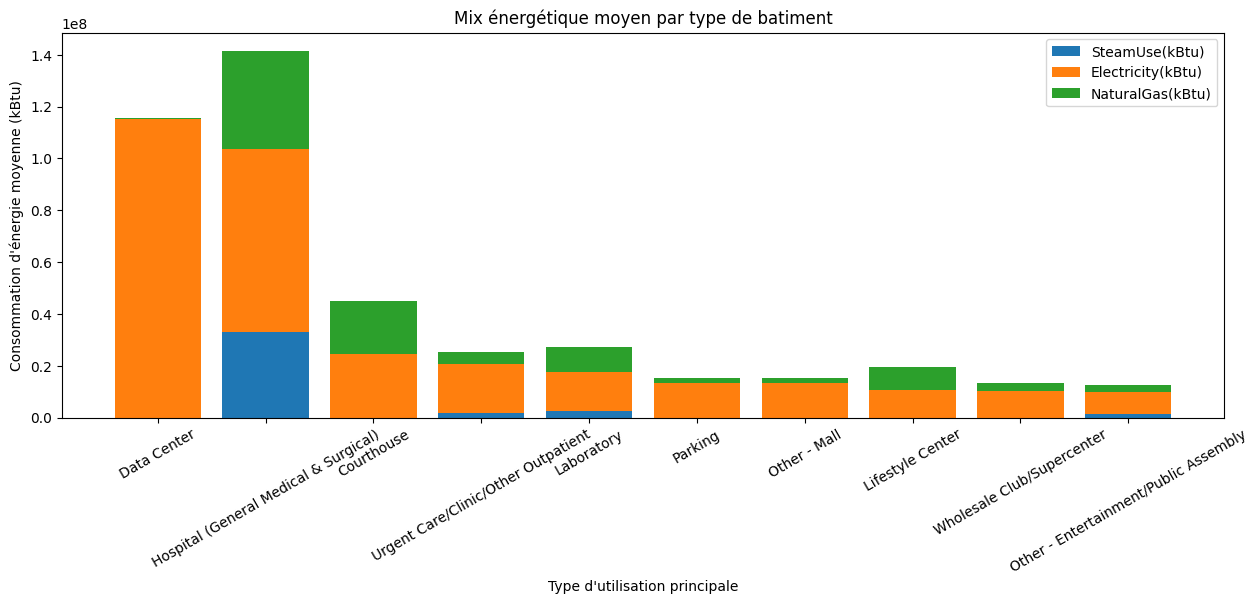

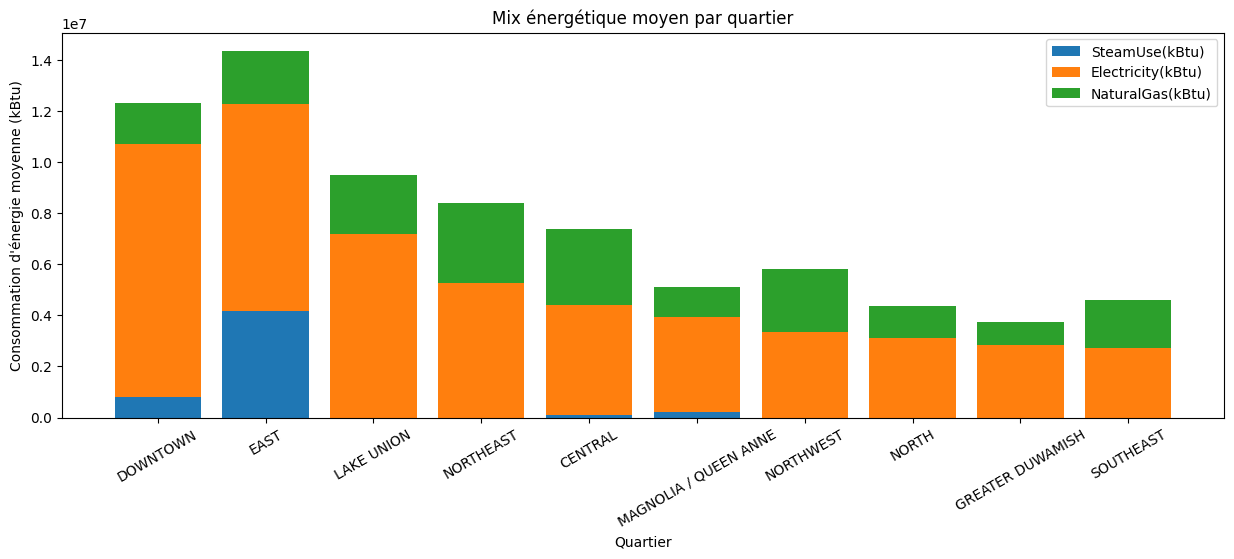

In [230]:
# mix énergétique moyen par type de batiment
plt.figure(figsize=(15, 5))
conso_values = energyMix_per_usage[['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']].head(10)
usage_types = conso_values.index

bottom = None
for col in conso_values.columns:
    plt.bar(usage_types, conso_values[col], label=col, bottom=bottom)
    if bottom is None:
        bottom = conso_values[col]
    else:
        bottom += conso_values[col]
plt.xlabel('Type d\'utilisation principale')
plt.xticks(rotation=30)
plt.ylabel('Consommation d\'énergie moyenne (kBtu)')
plt.title('Mix énergétique moyen par type de batiment')
plt.legend()
plt.show()


# mix énergétique moyen par quartier
plt.figure(figsize=(15, 5))
conso_values = energyMix_per_neighborhood[['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']].head(10)
neighborhood_name = conso_values.index

bottom = None
for col in conso_values.columns:
    plt.bar(neighborhood_name, conso_values[col], label=col, bottom=bottom)
    if bottom is None:
        bottom = conso_values[col]
    else:
        bottom += conso_values[col]
plt.xlabel('Quartier')
plt.xticks(rotation=30)
plt.ylabel('Consommation d\'énergie moyenne (kBtu)')
plt.title('Mix énergétique moyen par quartier')
plt.legend()
plt.show()

On observe que tous les bâtiments utilisent en majorité de l'éléctricité comme source d'énergie. Les hôtpitaux utilisent les 3 sources décrites dans la base de données.

Le quartier EAST abrite plusieurs hôpitaux ce qui explique la forte consommation en énergie thermique.

###**3. Cas du score énergétique**

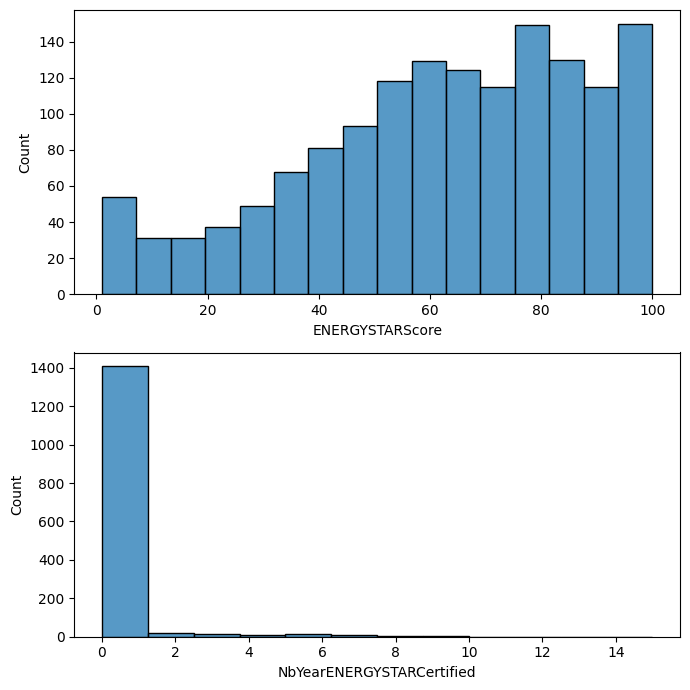

LastYearENERGYSTARCertified
0.0       1383
2016.0      33
2017.0      27
2009.0       6
2014.0       5
2015.0       5
2010.0       4
2013.0       4
2012.0       3
2011.0       3
2007.0       1
Name: count, dtype: int64


In [231]:
# univarié
L_num = ['ENERGYSTARScore', 'NbYearENERGYSTARCertified']
fig, axes = plt.subplots(nrows=len(L_num), ncols=1, figsize=(7,7))

for i, col in enumerate(L_num):
  df_graph = df[col]
  if col == 'LastYearENERGYSTARCertified':
    sns.histplot(x=df_graph.value_counts(), ax=axes[i])
  sns.histplot(x=df_graph, ax=axes[i])
plt.tight_layout()
plt.show()

print(df['LastYearENERGYSTARCertified'].value_counts())

In [232]:
# bivariée
## energy Star Score par usage
## energy Star Score par quartier
## energy Star Score selon l'age des batiments
energyStar_per_usage = df.groupby(['LargestPropertyUseType']).agg({'ENERGYSTARScore': 'mean'})
energyStar_per_usage.sort_values(by='ENERGYSTARScore', ascending=False, inplace=True)
print(energyStar_per_usage.head(10), end='\n\n')

energyStar_per_neighborhood = df.groupby(['Neighborhood']).agg({'ENERGYSTARScore': 'mean'})
energyStar_per_neighborhood.sort_values(by='ENERGYSTARScore', ascending=False, inplace=True)
print(energyStar_per_neighborhood.head(10))

                                                    ENERGYSTARScore
LargestPropertyUseType                                             
Data Center                                               98.000000
Personal Services (Health/Beauty, Dry Cleaning,...        87.333333
Courthouse                                                76.000000
Fire Station                                              75.666667
Pre-school/Daycare                                        73.666667
Adult Education                                           70.333333
Laboratory                                                69.025641
Office                                                    68.380262
College/University                                        67.870370
Parking                                                   67.643678

                       ENERGYSTARScore
Neighborhood                          
DOWNTOWN                     67.693462
NORTHWEST                    66.441441
LAKE UNION                 

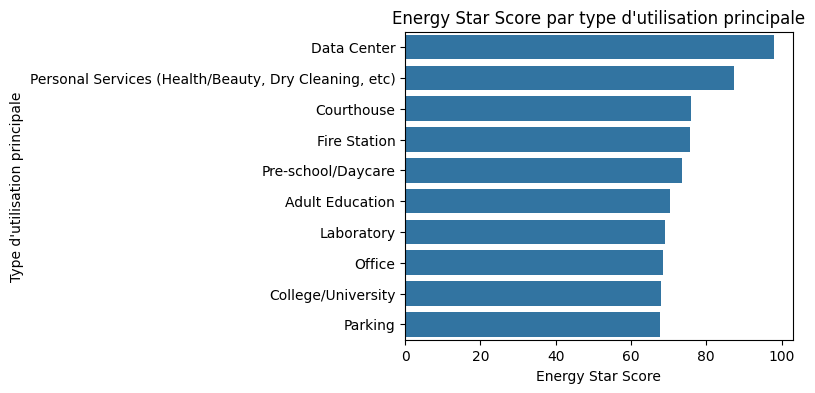

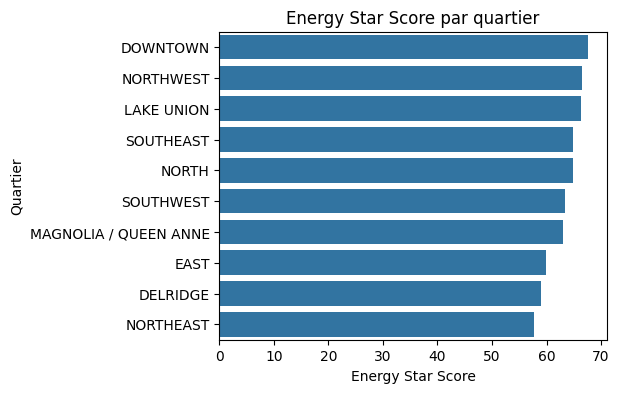

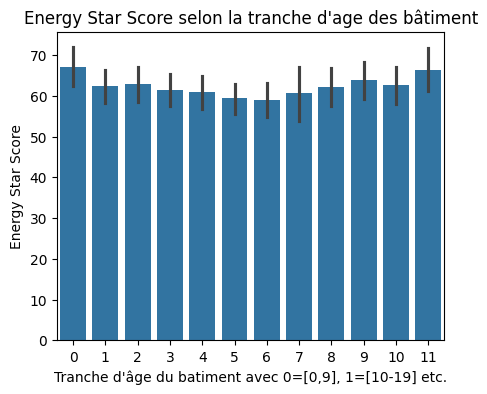

In [233]:
# par usage
plt.figure(figsize=(5, 4))
conso_values = energyStar_per_usage['ENERGYSTARScore'].head(10)
TOP10_GHG_USAGE_TYPES = conso_values.index
sns.barplot(x=conso_values, y=TOP10_GHG_USAGE_TYPES)
plt.ylabel('Type d\'utilisation principale')
plt.xlabel('Energy Star Score')
plt.title('Energy Star Score par type d\'utilisation principale')
plt.show()

# par quartier
plt.figure(figsize=(5, 4))
conso_values = energyStar_per_neighborhood['ENERGYSTARScore'].head(10)
TOP10_GHG_NEIGHBORHOOD_NAME = conso_values.index
sns.barplot(x=conso_values, y=TOP10_GHG_NEIGHBORHOOD_NAME)
plt.ylabel('Quartier')
plt.xlabel('Energy Star Score')
plt.title('Energy Star Score par quartier')
plt.show()

# par age
plt.figure(figsize=(5, 4))
df['Tranche_age'] = df['BuildingAge']//10
sns.barplot(x=df['Tranche_age'], y=df['ENERGYSTARScore'])
plt.xlabel('Tranche d\'âge du batiment avec 0=[0,9], 1=[10-19] etc.')
plt.ylabel('Energy Star Score')
plt.title('Energy Star Score selon la tranche d\'age des bâtiment')
plt.show()

df.drop(columns = 'Tranche_age', inplace=True)

Globalement, on observe une certaine homogénéïté pour l'Energy Star Score.

###**4. Matrice de corrélation en heatmap**

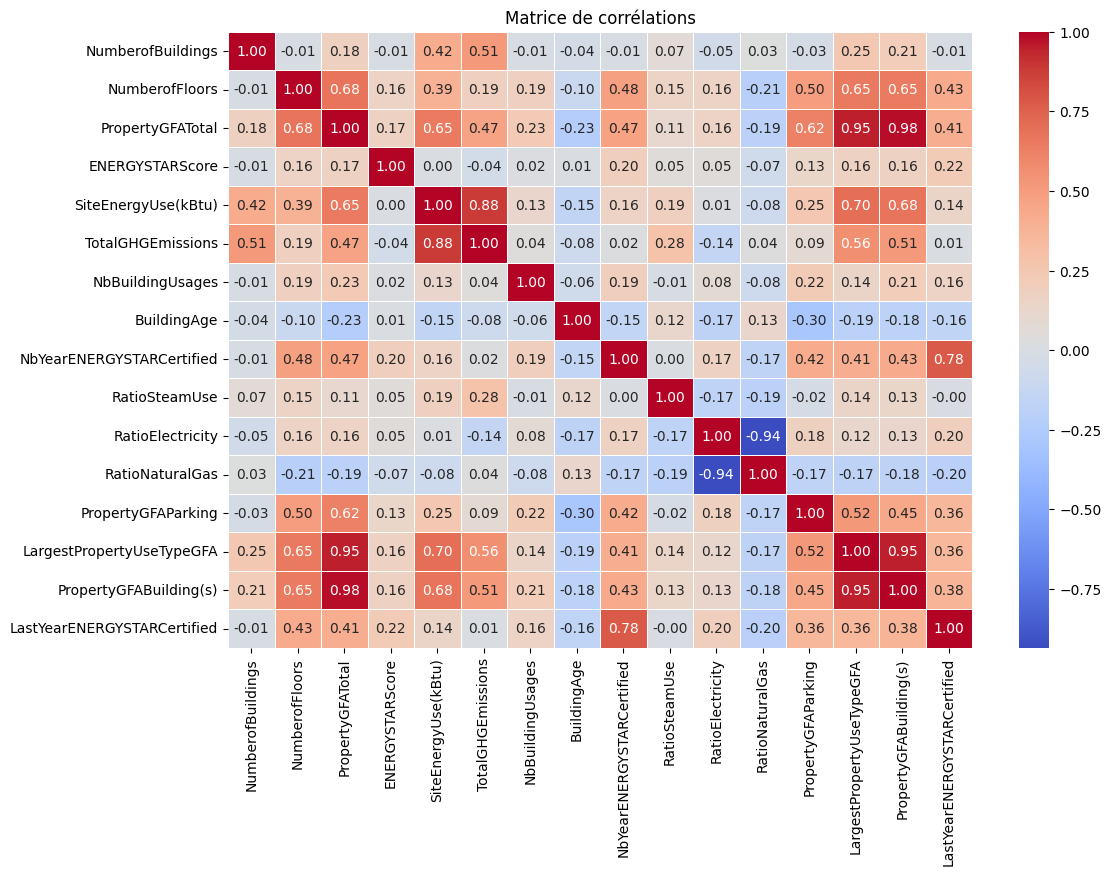

In [234]:
NUMERIC_FEATURES = ['NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'NbBuildingUsages',
       'BuildingAge', 'NbYearENERGYSTARCertified', 'RatioSteamUse',
       'RatioElectricity', 'RatioNaturalGas',
       'PropertyGFAParking', 'LargestPropertyUseTypeGFA', 'PropertyGFABuilding(s)', 'LastYearENERGYSTARCertified']

# retirer les variables qui génèrent du data leakage
df.drop(columns = ['SteamUse(kBtu)'], inplace=True)
df.drop(columns = ['Electricity(kBtu)'], inplace=True)
df.drop(columns = ['NaturalGas(kBtu)'], inplace=True)

# corrélation
plt.figure(figsize=(12, 8))
correlation_matrix = df[NUMERIC_FEATURES].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matrice de corrélations')
plt.show()

Les variables LargestPropertyUseTypeGFA, PropertyGFABuilding(s) et PropertyGFATotal sont corrélées entre elles. Je vais conserver PropertyGFATotal car connaitre la superficie totale est à priori plus informative que les 2 autres variables.

Idem pour les variables NbYearENERGYSTARCertified et LastYearENERGYSTARCertified. Je choisie de conserver la variable NbYearENERGYSTARCertified.

Idem pour les variables RatioElectricity et RatioSteamUse. Je choisie de conserver la variable NbYearENERGYSTARCertified.



In [235]:
# retirer les variables trop corrélées entre elles
df.drop(columns = ['LargestPropertyUseTypeGFA'], inplace=True)
df.drop(columns = ['PropertyGFABuilding(s)'], inplace=True)
df.drop(columns = ['LastYearENERGYSTARCertified'], inplace=True)
df.drop(columns = ['RatioNaturalGas'], inplace=True)

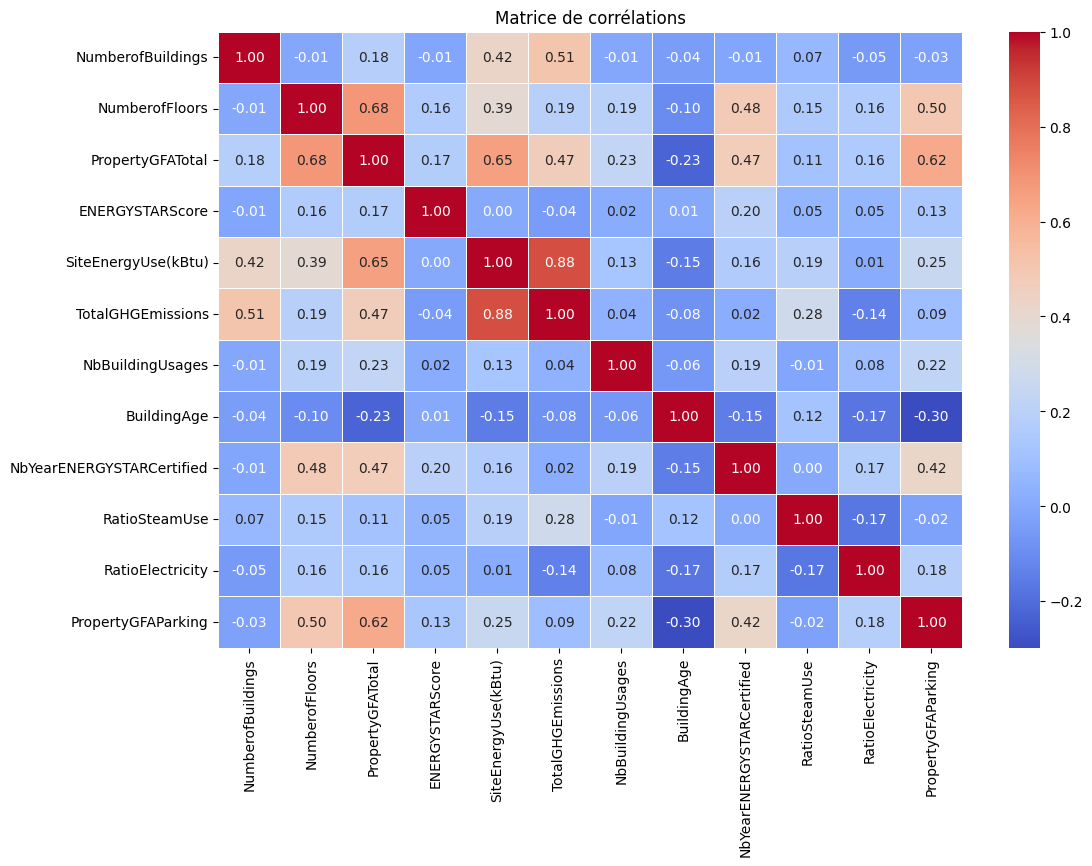

In [236]:
# corrélation
NUMERIC_FEATURES = ['NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'NbBuildingUsages',
       'BuildingAge', 'NbYearENERGYSTARCertified', 'RatioSteamUse',
       'RatioElectricity'
       , 'PropertyGFAParking']

plt.figure(figsize=(12, 8))
correlation_matrix = df[NUMERIC_FEATURES].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matrice de corrélations')
plt.show()

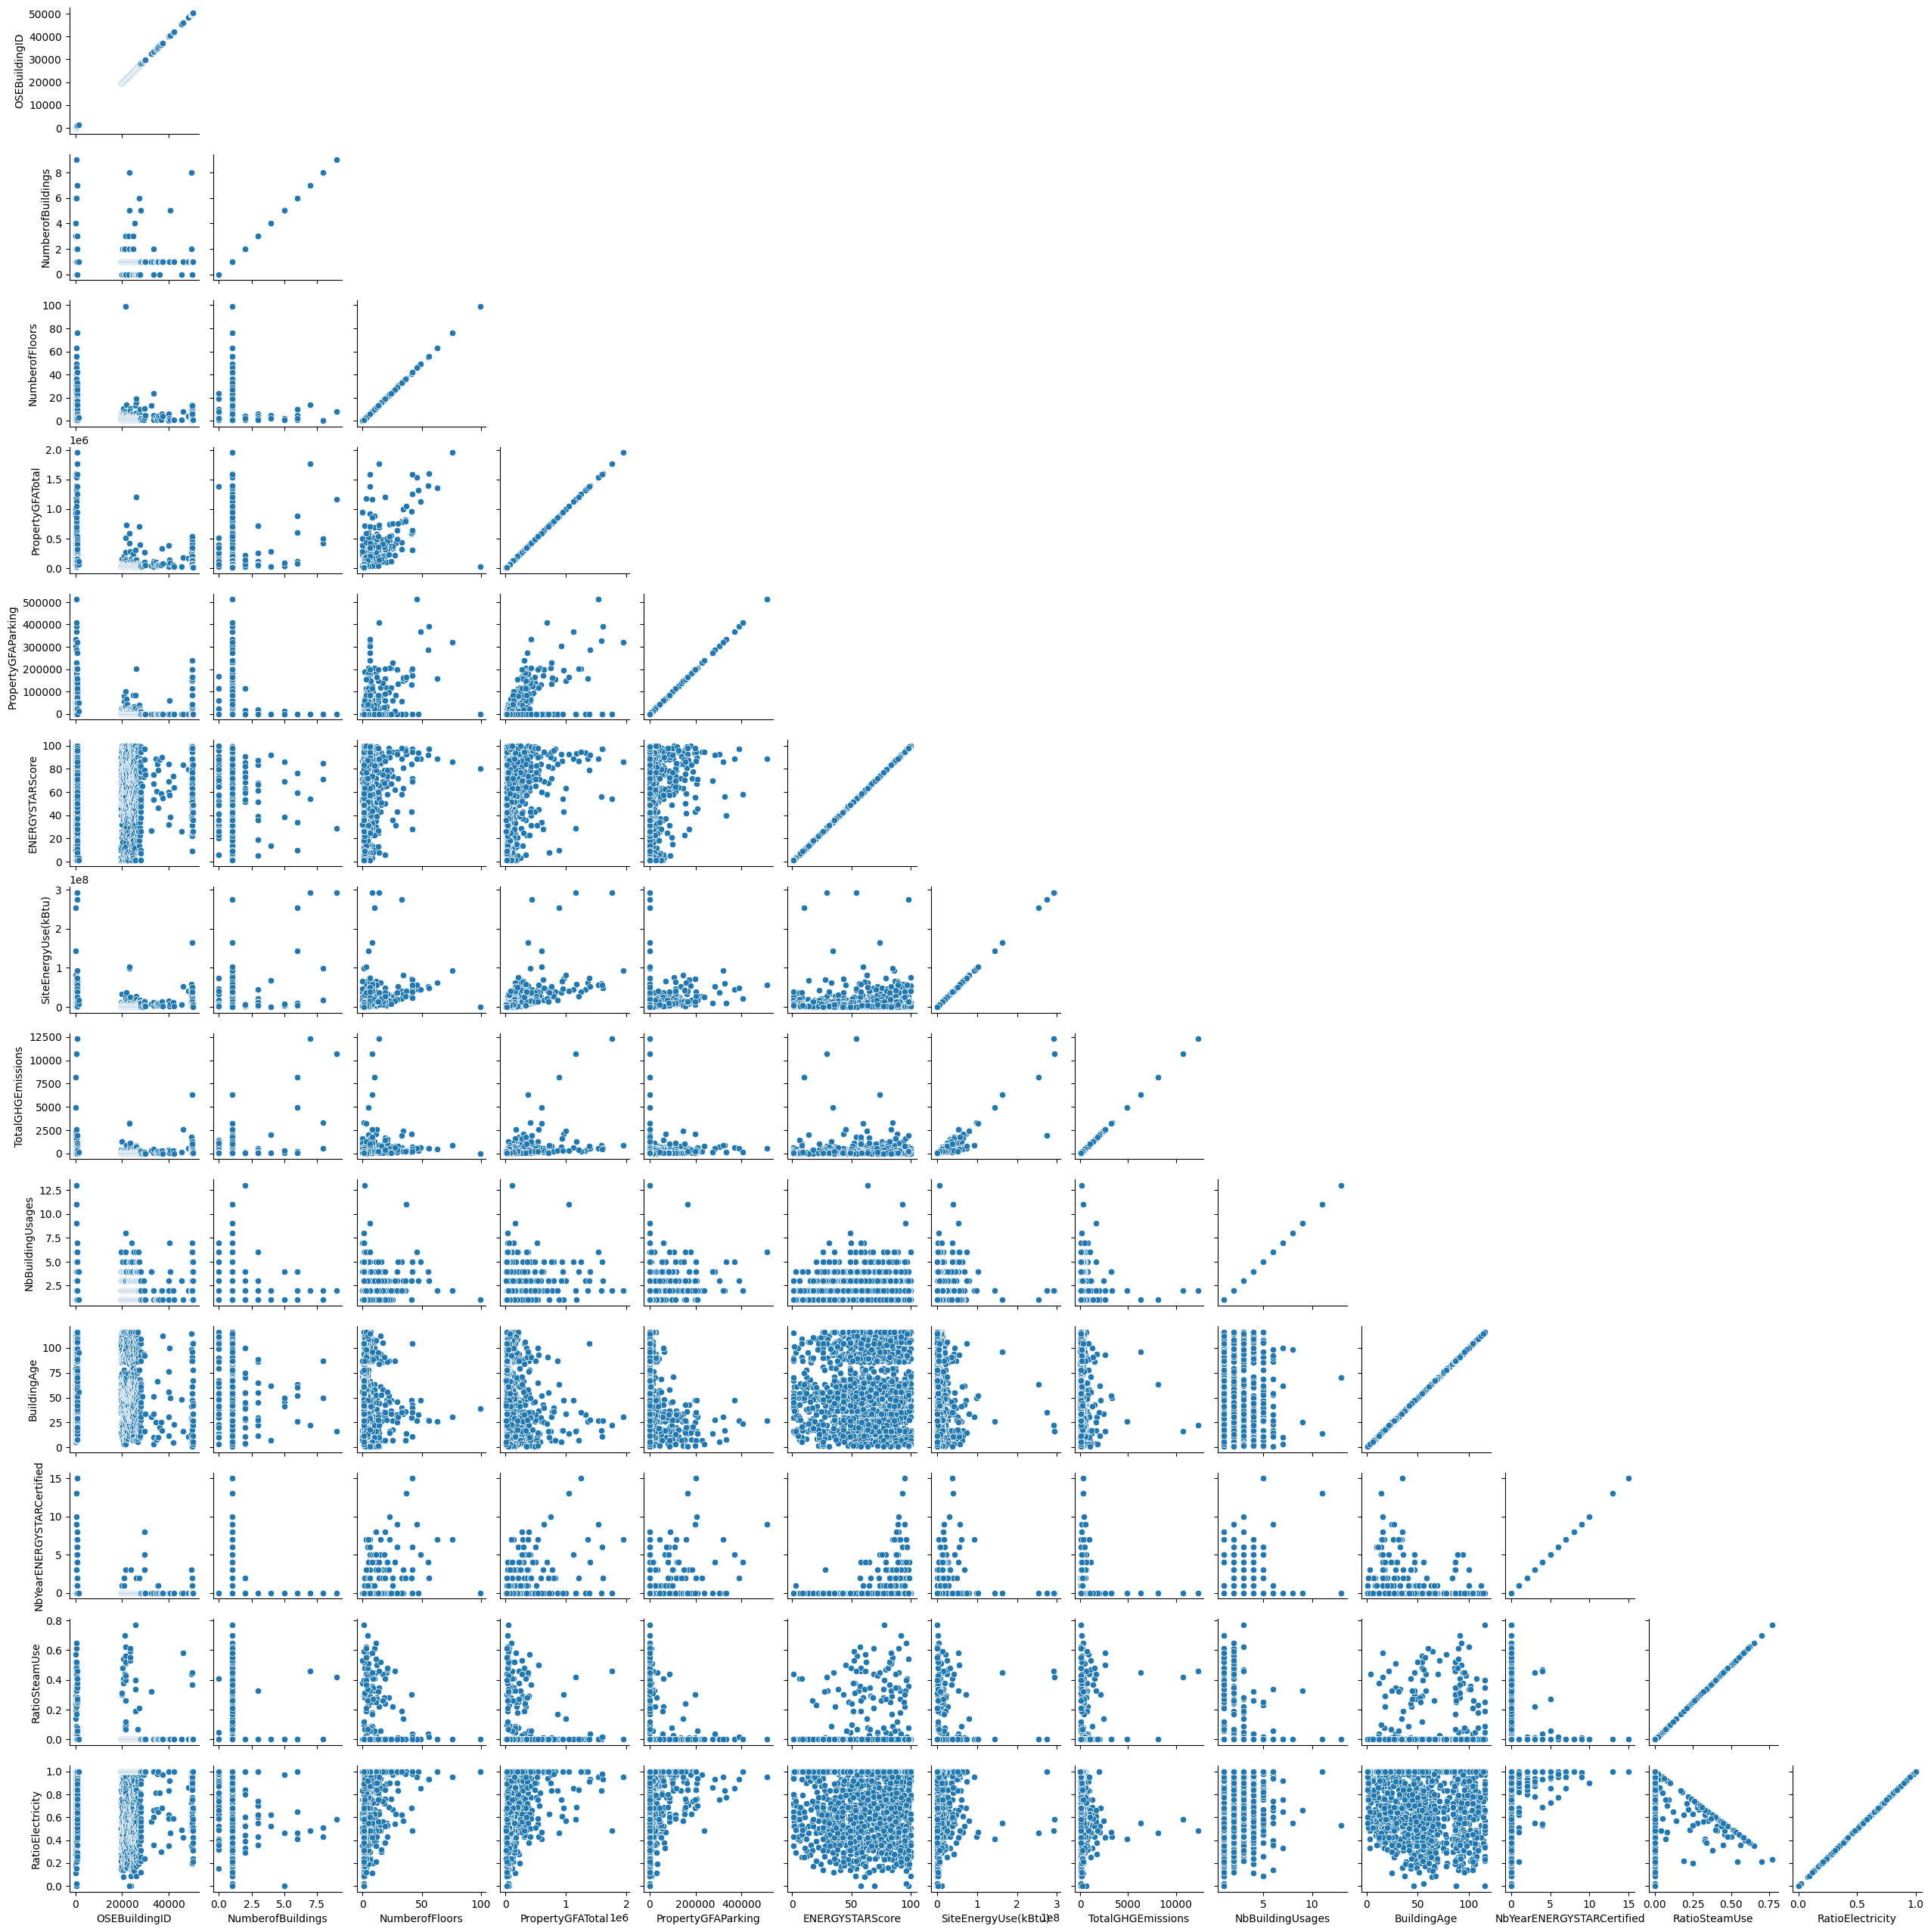

In [237]:
# nuage de points entre les variables quantitatives
sns.pairplot(df, height=2, diag_kind= None, corner=True)
plt.show()

# **Exportation du fichier nettoyé**

En conclusion, les variables explicatives retenues pour prédire TotalGHGEmissions et SiteEnergyUse(kBtu) sont autre nombre de 12:

- **LES RATIO DE CONSOMMATION ENERGETIQUE** (RatioSteamUse, RatioElectricity)
- **LE SCORE ENERGETIQUE** (ENERGYSTARScore, NbYearENERGYSTARCertified)
- **LES CARACTERISTIQUES PHYSIQUES DU BATIMENT**
(NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, BuildingAge)
- **LES USAGES** (LargestPropertyUseType, NbBuildingUsages)
- **LA LOCALISATION** (Neighborhood)


In [238]:
print(df.head())
print(df.columns)

   OSEBuildingID Neighborhood  NumberofBuildings  NumberofFloors  \
0              1     DOWNTOWN                1.0              12   
1              2     DOWNTOWN                1.0              11   
2              3     DOWNTOWN                1.0              41   
3              5     DOWNTOWN                1.0              10   
4              8     DOWNTOWN                1.0              18   

   PropertyGFATotal  PropertyGFAParking LargestPropertyUseType  \
0             88434                   0                  Hotel   
1            103566               15064                  Hotel   
2            956110              196718                  Hotel   
3             61320                   0                  Hotel   
4            175580               62000                  Hotel   

   ENERGYSTARScore  SiteEnergyUse(kBtu)  TotalGHGEmissions  NbBuildingUsages  \
0             60.0            7226362.5             249.98                 1   
1             61.0            8387

In [239]:
# fin de l'analyse
## exportation du fichier nettoyé
df.reset_index(drop=True).to_parquet('/content/drive/MyDrive/openclassrooms/project_list/project_4/data/cleaned_2016_Building_Energy_Benchmarking.pq')